In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scanpy as sc

In [87]:
import echidna as ec
ec.pl.activate_plot_settings()

In [246]:
adata = sc.read_h5ad("PTO046.rna.h5ad")

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [247]:
adata.var_names_make_unique()

In [248]:
adata = adata[[i for i in adata.obs_names if (adata.obs.loc[i]["cell_type"] =='Tumor_EGFR' or adata.obs.loc[i]["cell_type"]=='Tumor_PDGFRA')]]

In [249]:
adata.obs["rna_cluster"]=pd.Categorical(adata.obs["rna_cluster"])

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_7366/397924301.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["rna_cluster"]=pd.Categorical(adata.obs["rna_cluster"])


In [250]:
wdf = pd.read_csv("w_run13.csv",index_col='0')

In [251]:
wdf = wdf.loc[np.intersect1d(wdf.index, adata.var_names)]
adata = adata[:, np.intersect1d(wdf.index, adata.var_names)]

In [252]:
adata.layers["counts"] = adata.X
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.obs['original_total_counts'] = adata.obs['total_counts']

# log10 original library size
adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])

# Normalize by median library size
med = np.median(adata.obs['original_total_counts'])
sc.pp.normalize_total(adata, target_sum = med)
sc.pp.log1p(adata)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_7366/4040235861.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X


In [253]:
sc.pp.neighbors(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [254]:
sc.tl.leiden(adata)
sc.tl.umap(adata)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_7366/3341371877.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


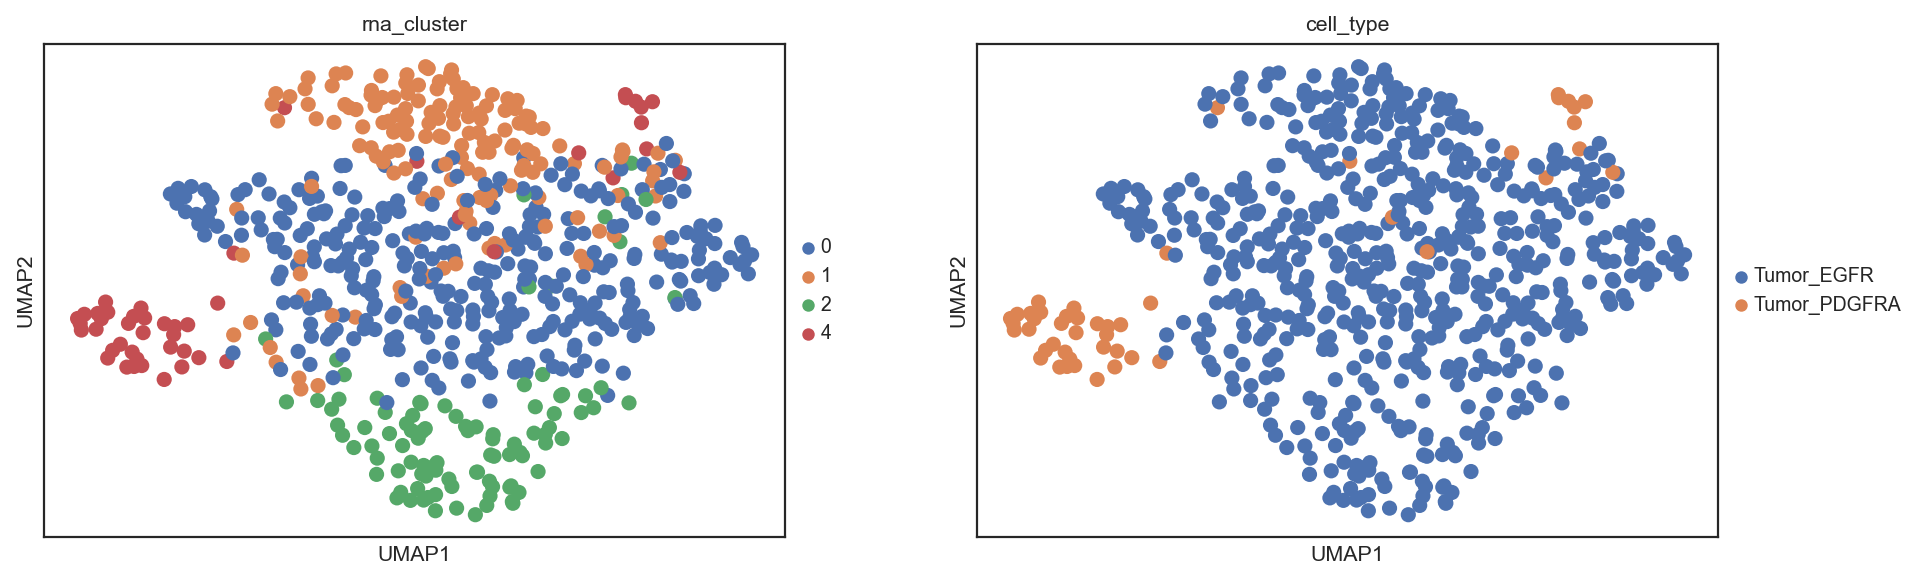

In [255]:
sc.pl.umap(adata,color=["rna_cluster","cell_type"])

In [265]:
adata.layers["counts"] = adata.layers["counts"].toarray()

In [266]:
adata.obs["timepoint"]=['T1' for i in range(adata.shape[0])]

2025-06-23 16:51:01,643 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 64 cells in validation set.
2025-06-23 16:51:01,652 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
2025-06-23 16:51:01,654 | WARNING : `rna_cluster` changed to `rna_cluster_categorical`.
training loss: 0.8539 | validation loss: 0.1936: 100%|█████████████████████████████████████████████| 6000/6000 [17:45<00:00,  5.63it/s]


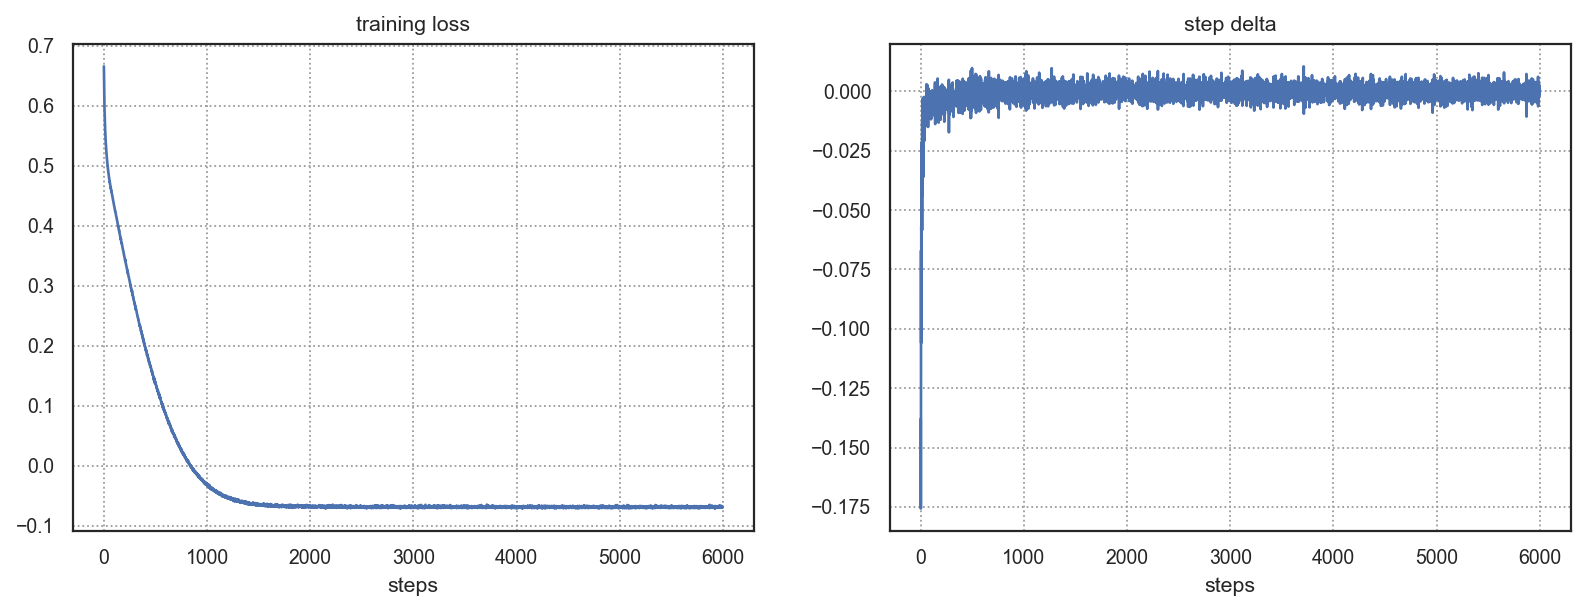

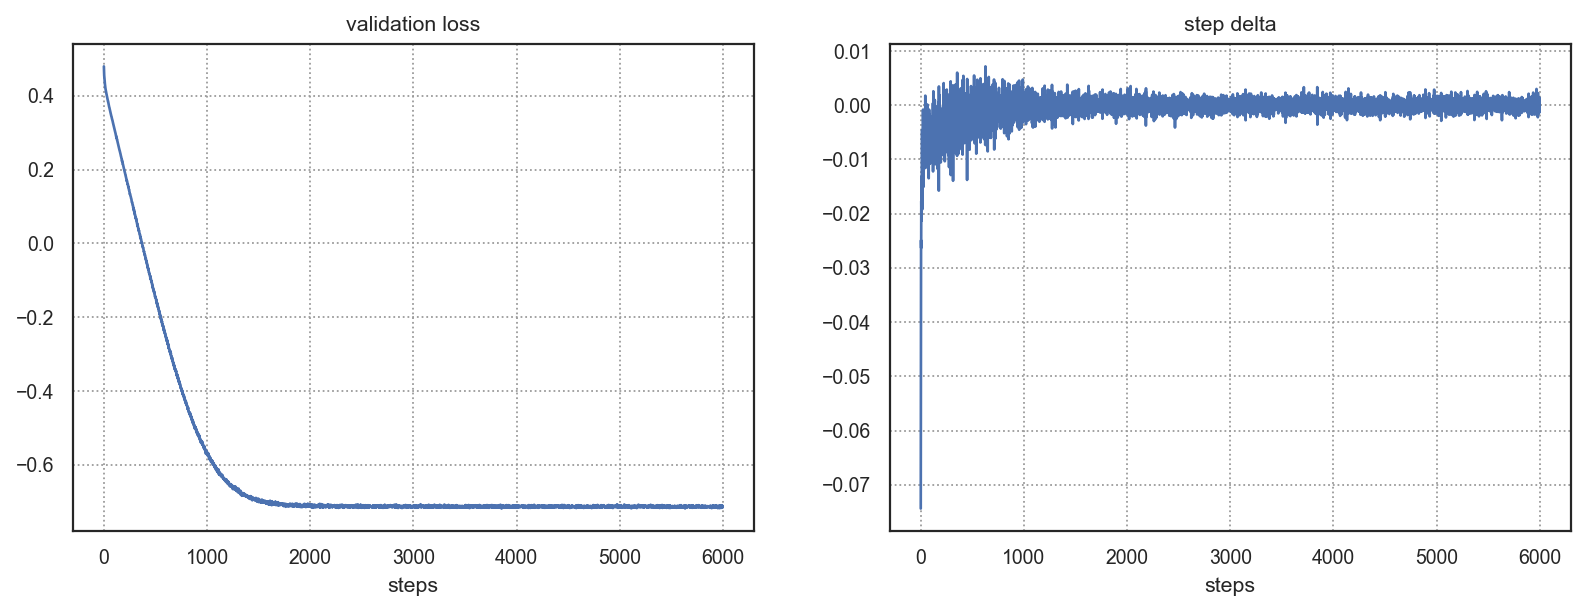

2025-06-23 17:08:59,063 | INFO : Overwriting existing echidna model.


In [579]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "rna_cluster", # `assert 'leiden' in adata.obs.columns`
    inverse_gamma = True, # Inverse Gamma False when we have more data
    patience = None, # Increase/decrease to affect early stopping, None for no early stopping (default)
    n_steps = 6000,
    val_split = .1,
    learning_rate = .1,
    q_corr_init = 1e-2, # See README.md for model hyperparam descriptions
    q_shape_rate_scaler = 10.0,
    eta_mean_init = 2.0,
    lkj_concentration = 1.0,
)
ec.tl.echidna_train(
     adata # Single-cell AnnData
    , wdf # Copy number  pd.DataFrame, indexed with genes
    , config # Config settings
)

In [142]:
ec.tl.load_model(adata)

In [580]:
ec.tl.echidna_clones(adata, threshold=0.025)

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/echidna/tools/eval.py:356: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in adata.obs[cluster_label]]
2025-06-23 17:09:00,936 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


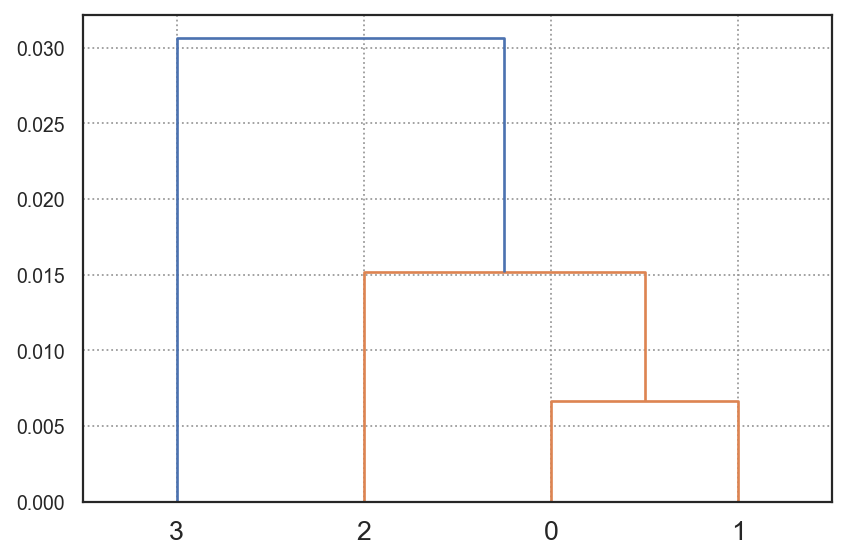

In [581]:
ec.pl.dendrogram(adata)

In [606]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.15',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',

In [286]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'axes.labelsize' : 'large'}) 
plt.rcParams.update({'axes.titlesize' : 20}) 
plt.rcParams.update({'legend.fontsize': 15})

In [659]:
pal = {"C1":"salmon","C2":"teal","Tumor_EGFR":"pink","Tumor_PDGFRA":"turquoise",
      0:"blue",1:"orange",2:"green",3:"red"}

2025-06-25 12:28:52,475 | INFO : maxp pruned
2025-06-25 12:28:52,475 | INFO : LTSH dropped
2025-06-25 12:28:52,476 | INFO : cmap pruned
2025-06-25 12:28:52,476 | INFO : kern dropped
2025-06-25 12:28:52,479 | INFO : post pruned
2025-06-25 12:28:52,479 | INFO : PCLT dropped
2025-06-25 12:28:52,479 | INFO : JSTF dropped
2025-06-25 12:28:52,480 | INFO : DSIG dropped
2025-06-25 12:28:52,482 | INFO : GPOS pruned
2025-06-25 12:28:52,483 | INFO : GSUB pruned
2025-06-25 12:28:52,485 | INFO : glyf pruned
2025-06-25 12:28:52,486 | INFO : Added gid0 to subset
2025-06-25 12:28:52,487 | INFO : Added first four glyphs to subset
2025-06-25 12:28:52,487 | INFO : Closing glyph list over 'GSUB': 36 glyphs before
2025-06-25 12:28:52,487 | INFO : Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'M', 'P', 'R', 'T', 'U', 'a', 'c', 'd', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'y', 'zero']
2025-06-25 12:28:52,4

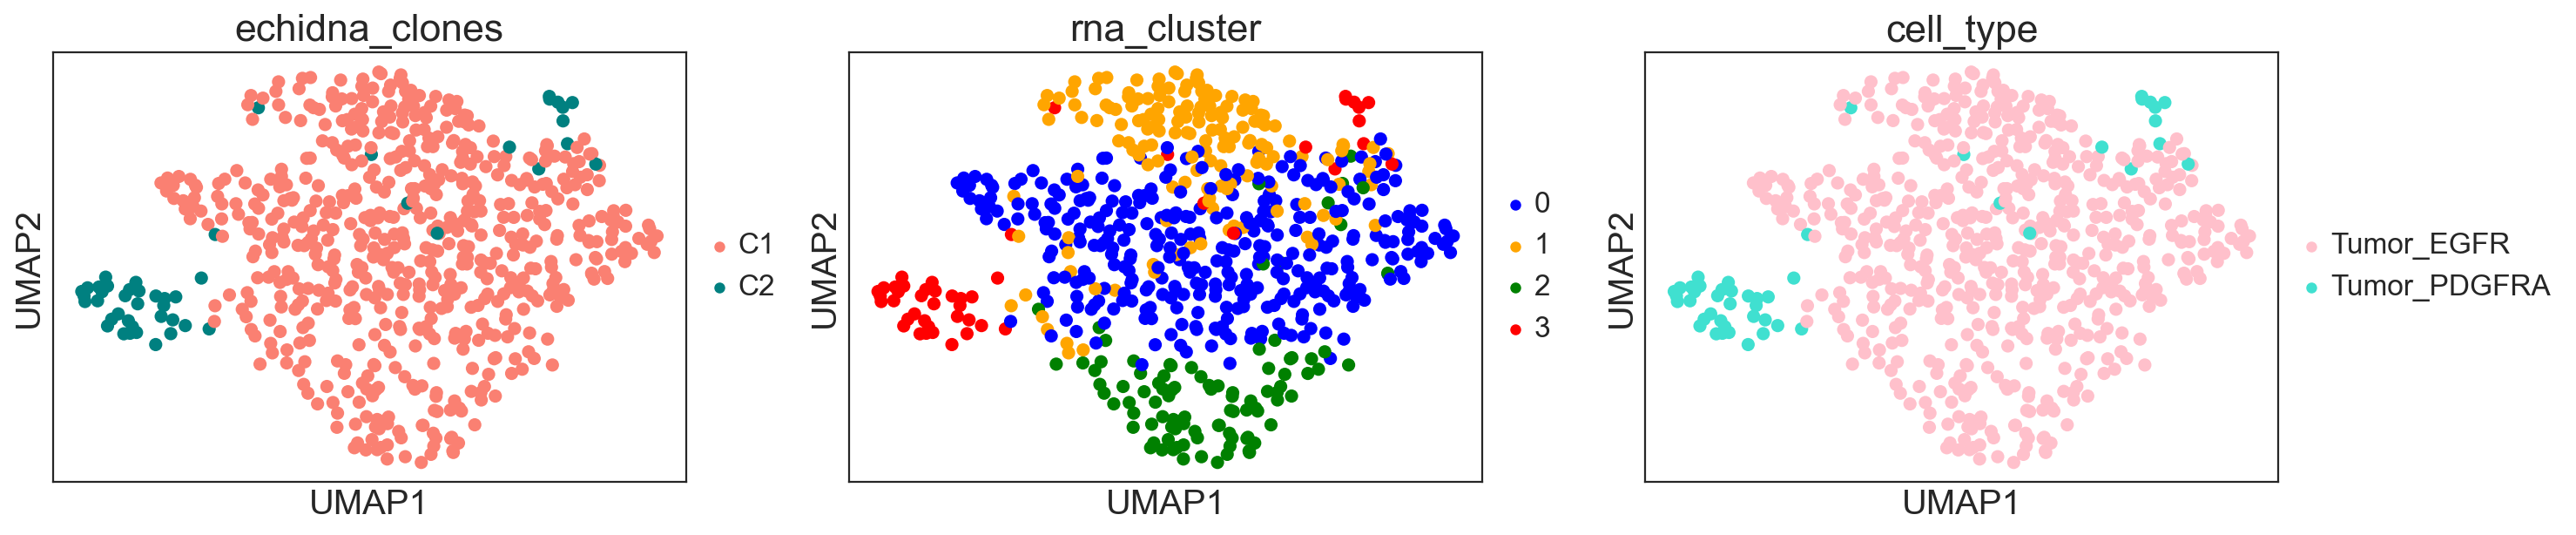

In [660]:
adata.obs["rna_cluster"] = pd.Categorical(adata.obs["rna_cluster"])
sc.pl.umap(adata, color=["echidna_clones", "rna_cluster","cell_type"], palette=pal, save='defnd_clusters.pdf')

2025-06-25 12:06:43,470 | INFO : maxp pruned
2025-06-25 12:06:43,471 | INFO : LTSH dropped
2025-06-25 12:06:43,471 | INFO : cmap pruned
2025-06-25 12:06:43,472 | INFO : kern dropped
2025-06-25 12:06:43,474 | INFO : post pruned
2025-06-25 12:06:43,474 | INFO : PCLT dropped
2025-06-25 12:06:43,474 | INFO : JSTF dropped
2025-06-25 12:06:43,475 | INFO : DSIG dropped
2025-06-25 12:06:43,477 | INFO : GPOS pruned
2025-06-25 12:06:43,478 | INFO : GSUB pruned
2025-06-25 12:06:43,480 | INFO : glyf pruned
2025-06-25 12:06:43,482 | INFO : Added gid0 to subset
2025-06-25 12:06:43,482 | INFO : Added first four glyphs to subset
2025-06-25 12:06:43,482 | INFO : Closing glyph list over 'GSUB': 21 glyphs before
2025-06-25 12:06:43,482 | INFO : Glyph names: ['.notdef', '.null', 'A', 'D', 'E', 'F', 'G', 'M', 'P', 'R', 'U', 'five', 'four', 'nonmarkingreturn', 'one', 'period', 'six', 'space', 'three', 'two', 'zero']
2025-06-25 12:06:43,483 | INFO : Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 3

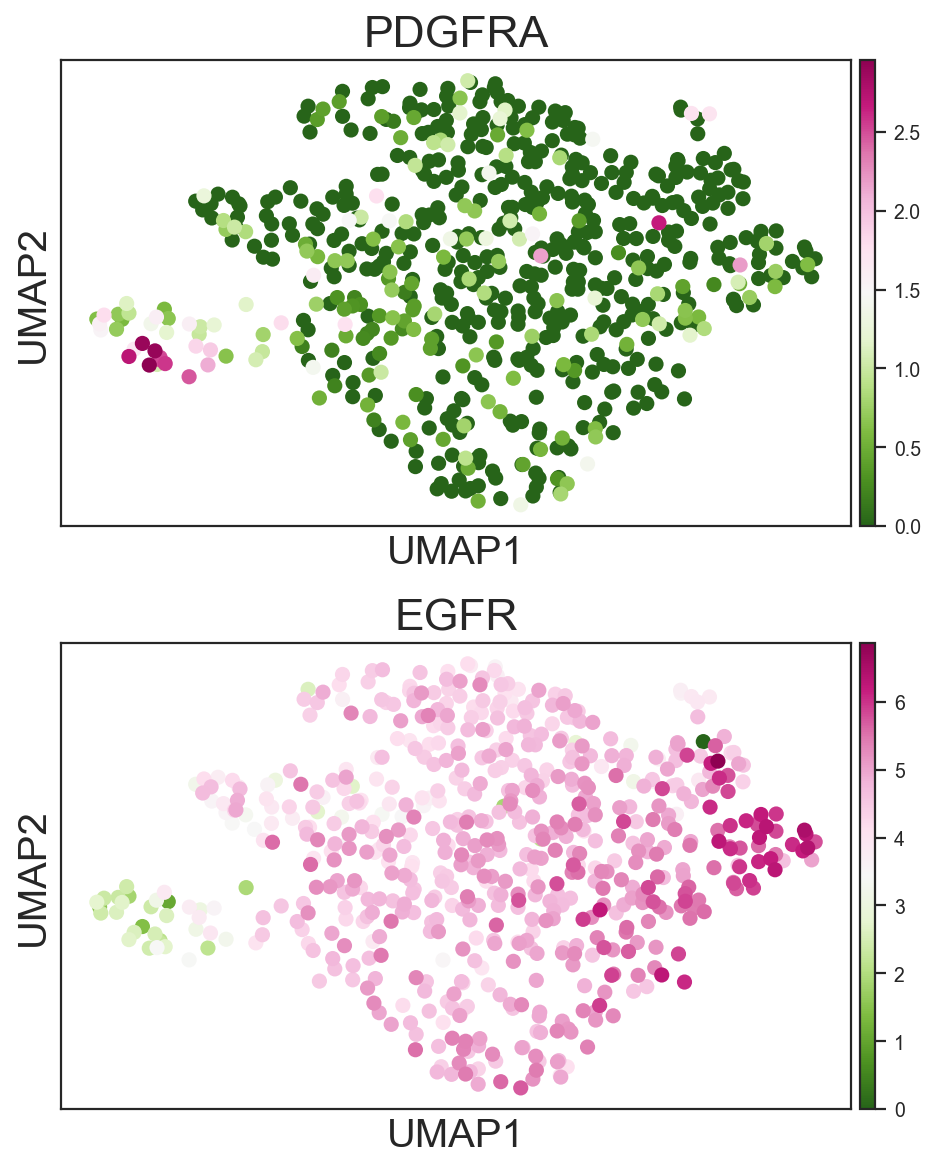

In [652]:
sc.pl.umap(adata,color=["PDGFRA","EGFR"], ncols=1, cmap='PiYG_r', save='defnd_genes.pdf')

2025-06-23 17:09:05,644 | INFO : `genome` not set, defaulting to hg38wgEncodeGencodeCompV46.


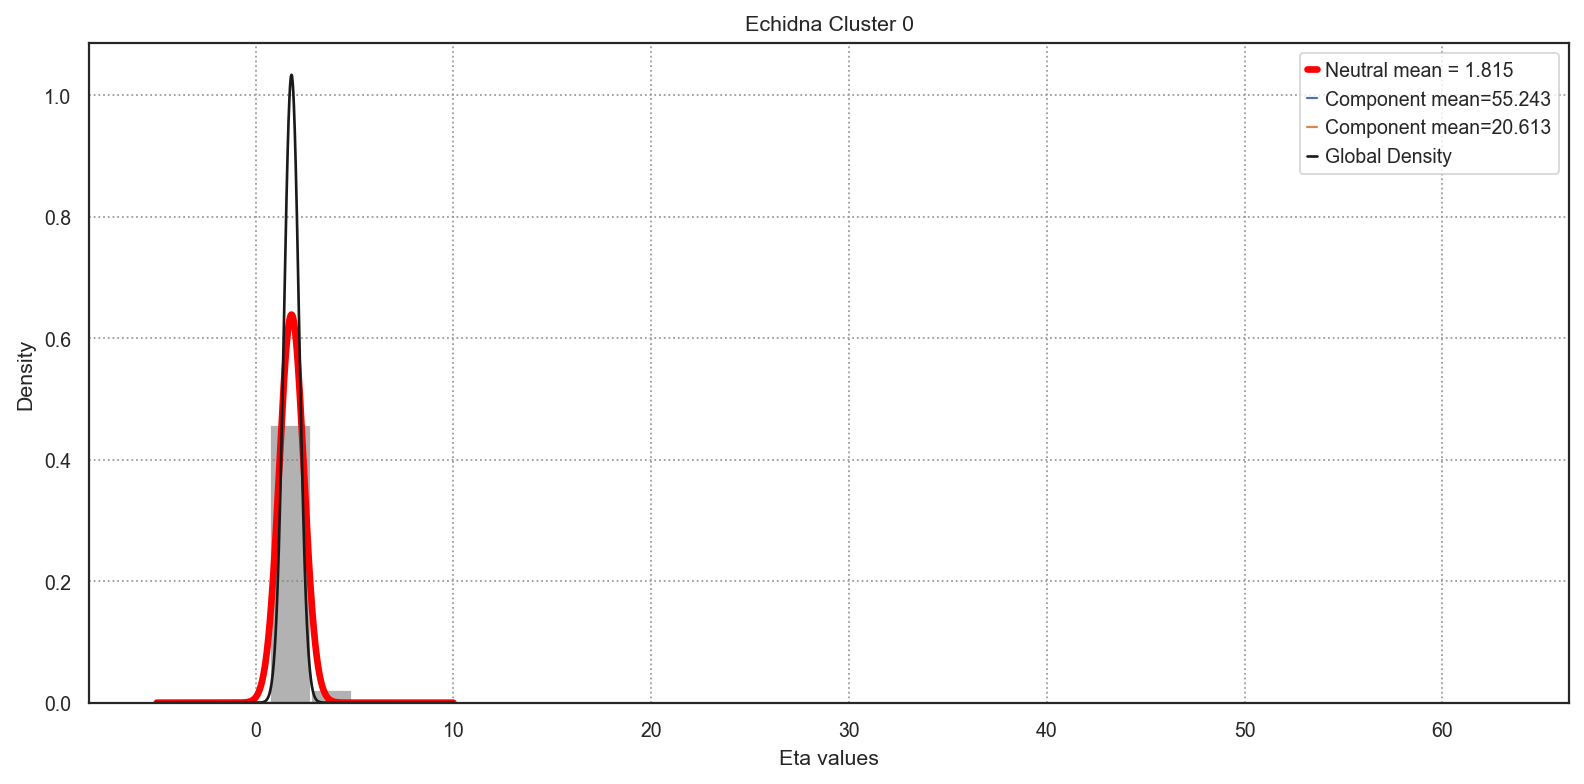

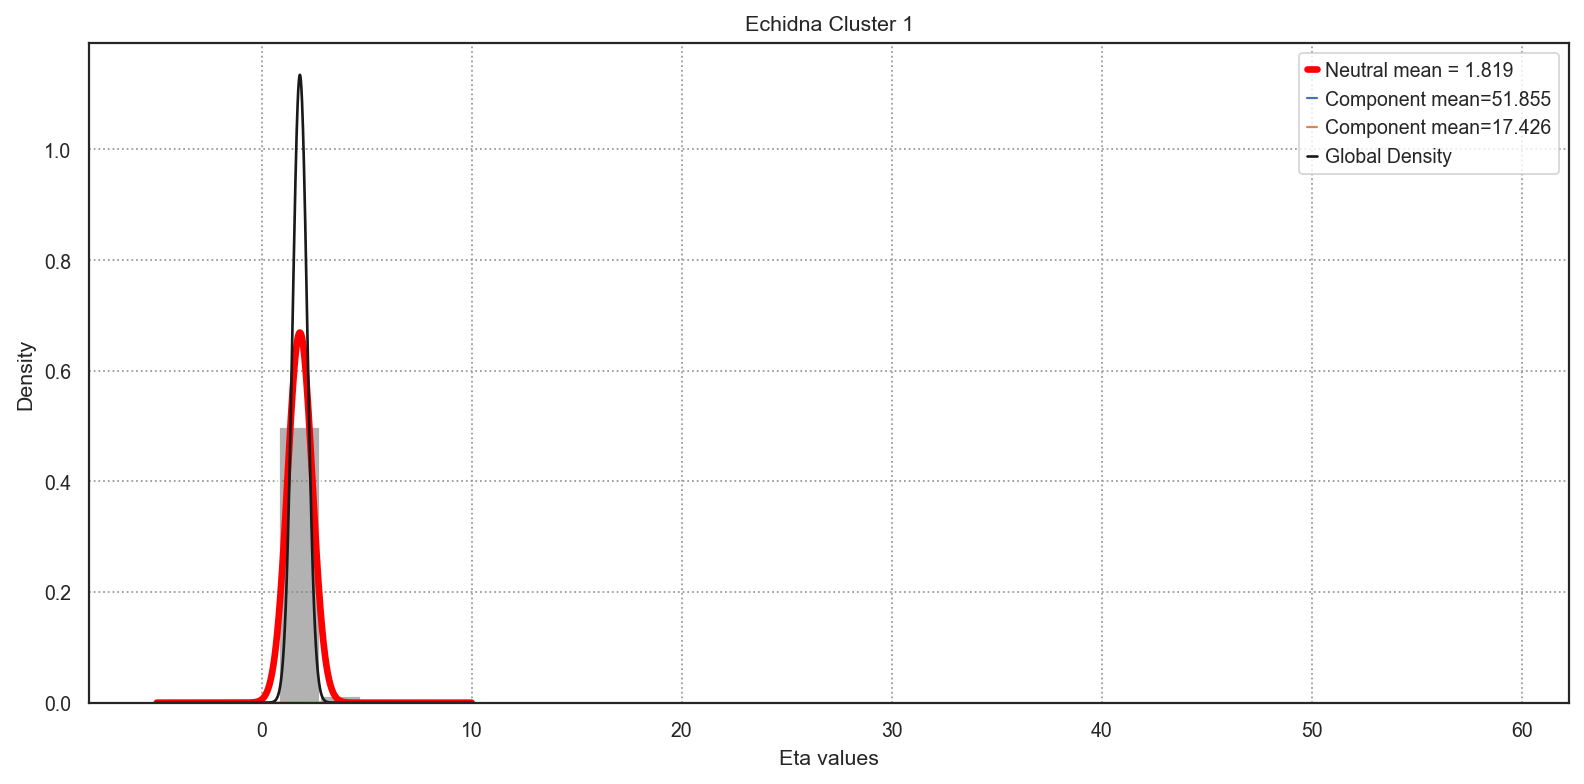

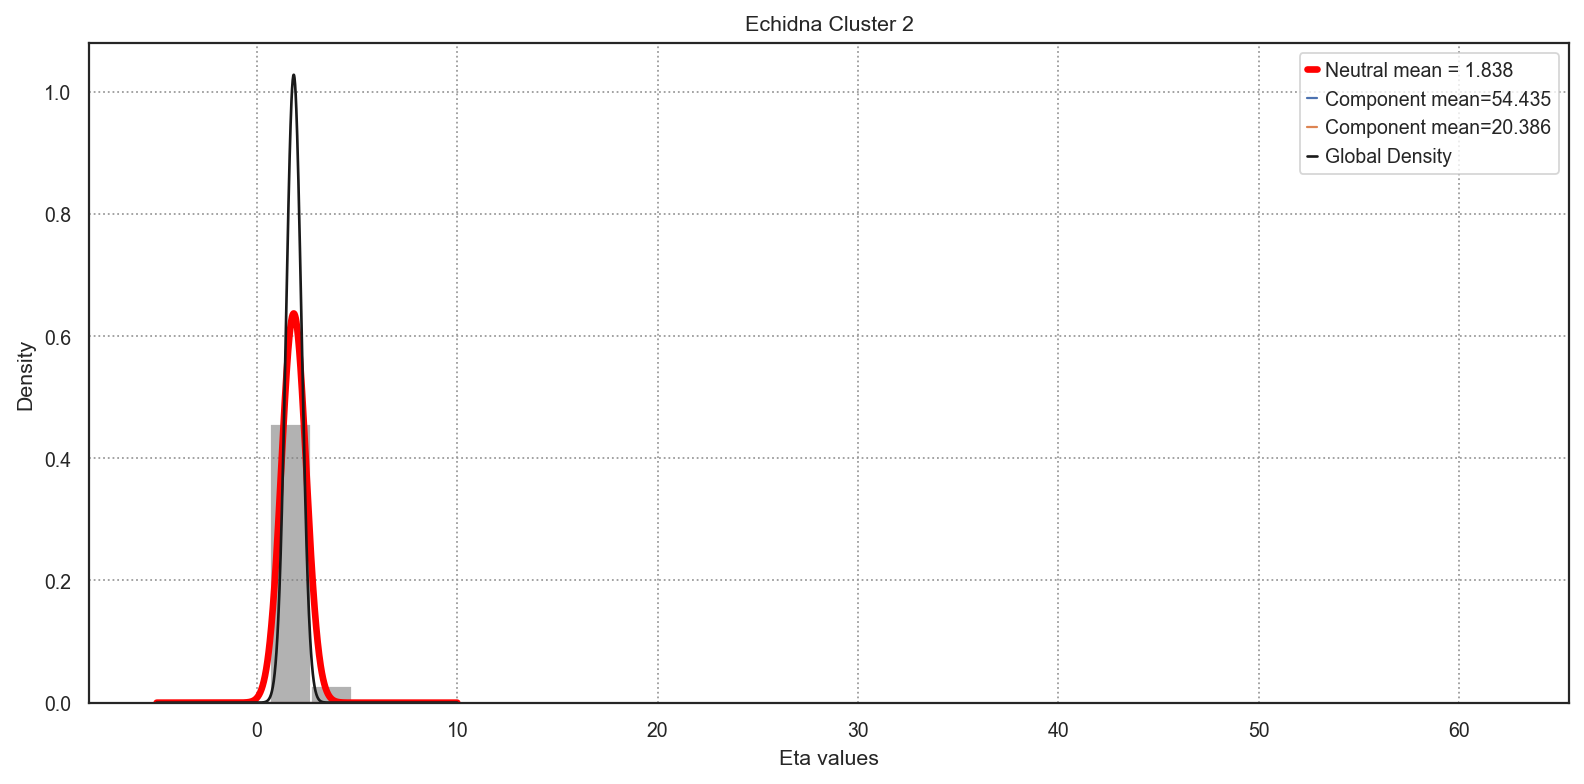

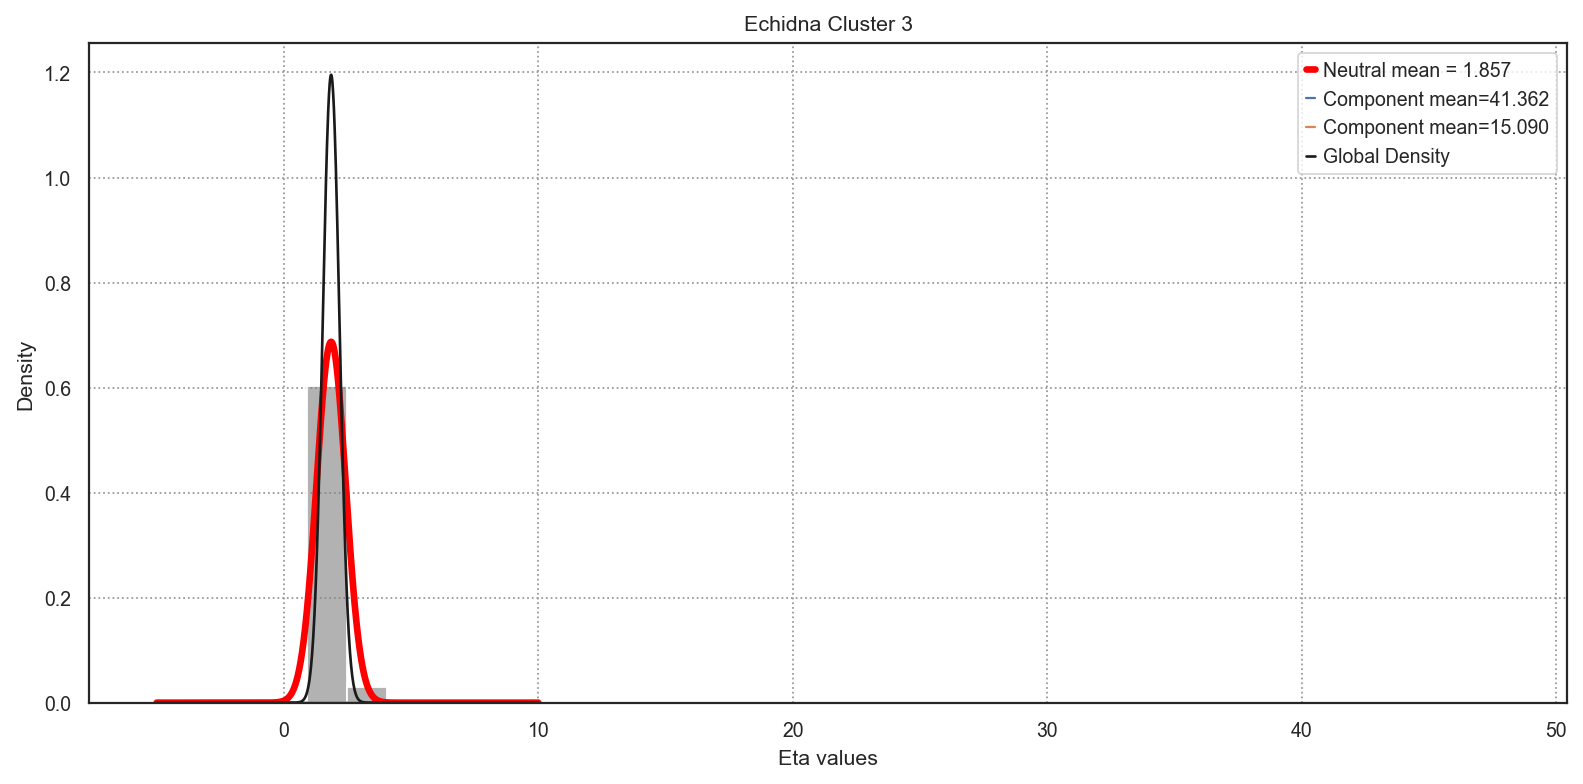

2025-06-23 17:09:14,019 | INFO : Added `.uns['echidna']['save_data']['echi_cnv']` : Path to CNV inference results.
Added `.uns['echidna']['save_data']['gmm_neutrals']` : Path to Echidna cluster neutral value results.


In [583]:
ec.tl.echi_cnv(adata, plot_gmm=True, n_gmm_components=3)

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/echidna/plot/post.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ticks = [(chrom_counts[i-1] + chrom_counts[i])/2 if i != 0 else chrom_counts[i]/2 for i in range(len(chrom_counts))]


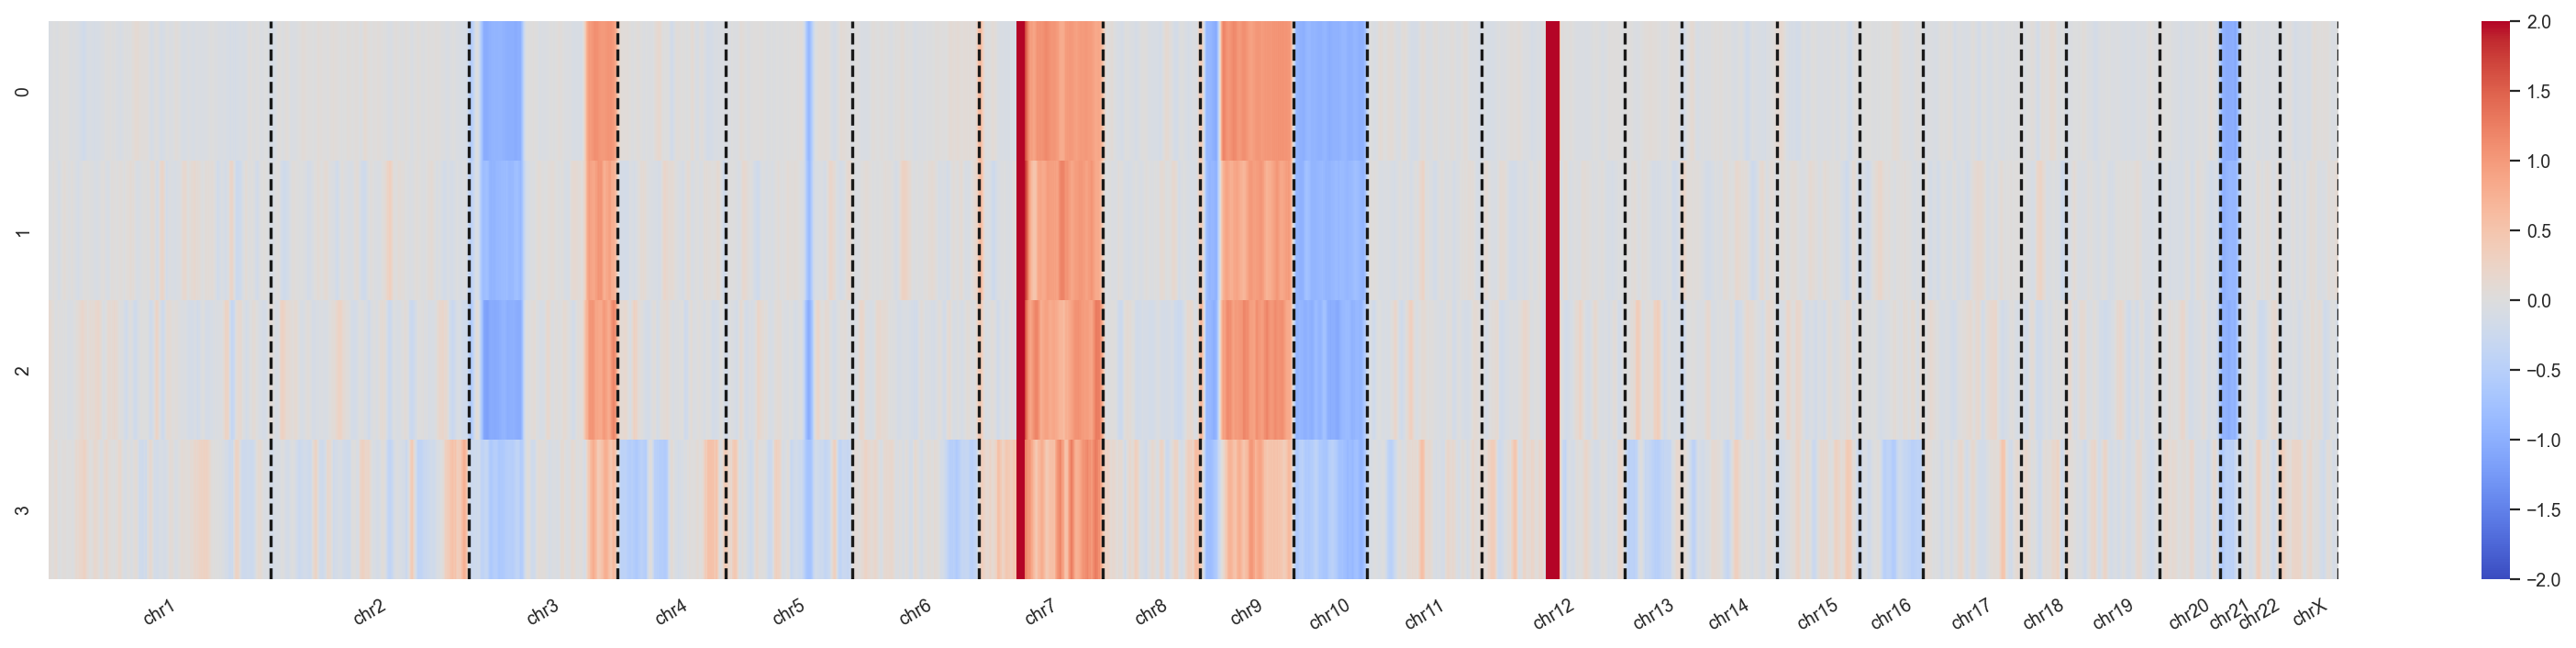

In [584]:
ec.pl.plot_eta(adata)

In [585]:
model = ec.tl.load_model(adata)

eta = pd.DataFrame(model.eta_posterior.detach().numpy())
eta.columns = adata.var_names
eta = eta[[i for i in wdf.index if i in eta.columns]]

In [586]:
short_eta = ec.tl.cnv_results(adata).drop("chrom",axis=1)
cnvs = short_eta[[i for i in short_eta.columns if "clone" in i and "states" not in i]]

In [649]:
adata.write_h5ad("DEFND_6k_steps.h5")

In [257]:
adata = sc.read_h5ad("DEFND_6k_steps.h5")
cnvs = pd.read_csv("DEFND_6k_steps_eta.csv", index_col=0)

In [105]:
wdf["tmp"]=["W" for i in range(wdf.shape[0])]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_7366/1501433394.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if wdf['1'][i]>20 and "ENS" not in wdf.index[i]:
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_7366/1501433394.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(rands[i],wdf['1'][i], wdf.index[i]))
2025-07-03 13:31:36,669 | INFO : maxp pruned
2025-07-03 13:31:36,670 | INFO : LTSH dropped
2025-07-03 13:31:36,670 | INFO : cmap pruned
2025-07-03 13:31:36,670 | INFO : kern dropped
2025-07-03 13:31:36,673 | INFO : post pruned
2025-07-03 13:31:36,673 | INFO : PC

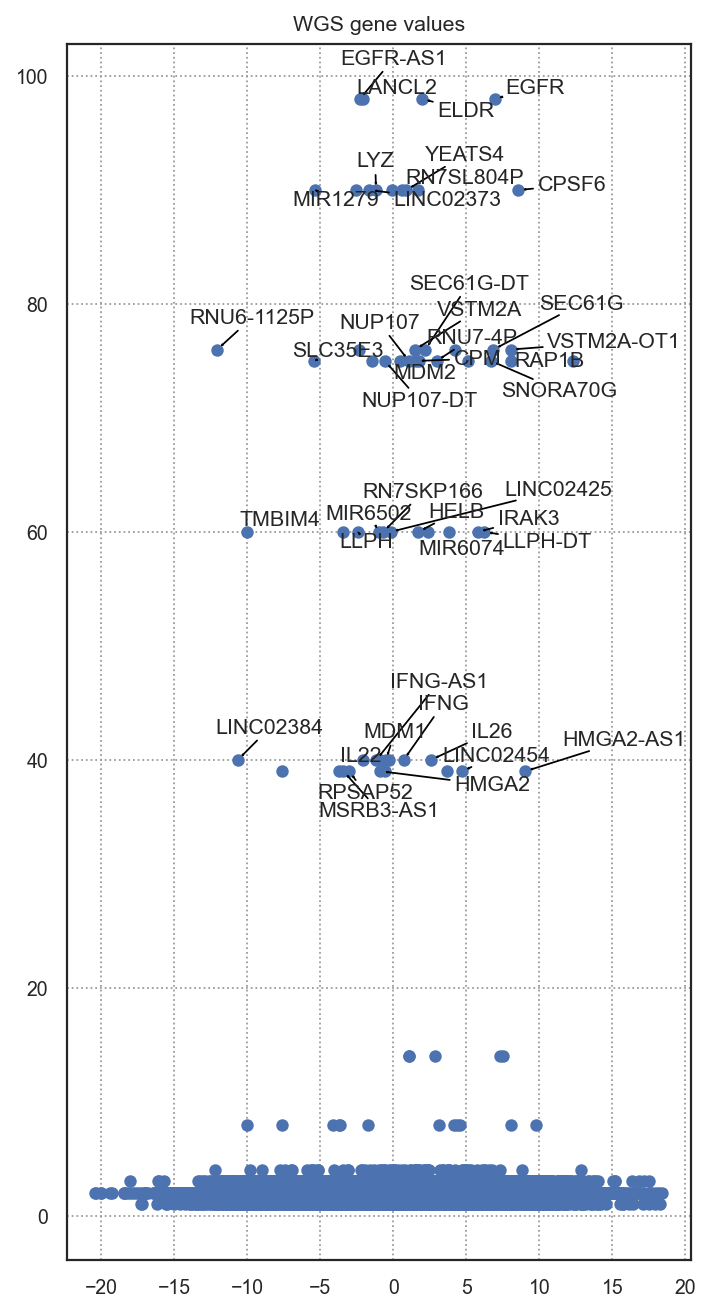

In [132]:
rands = np.random.normal(0,5,size=wdf.shape[0])
plt.figure(figsize=(5,10))
plt.scatter(rands,wdf['1'])
texts = []
for i in range(wdf.shape[0]):
    if wdf['1'][i]>20 and "ENS" not in wdf.index[i]:
        texts.append(plt.text(rands[i],wdf['1'][i], wdf.index[i]))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
plt.title("WGS gene values")
plt.savefig("WGS_values.pdf")

In [650]:
cnvs.to_csv("DEFND_6k_steps_eta.csv")

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


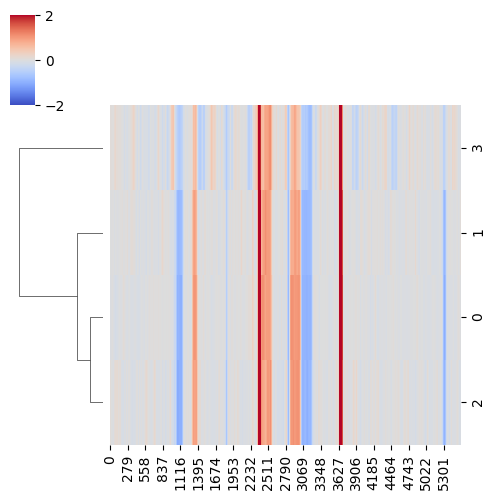

In [7]:
cl = sns.clustermap(scipy.ndimage.gaussian_filter1d(cnvs.T, sigma=10), cmap='coolwarm', vmin=-2, vmax=2, col_cluster=False, figsize=(5,5))

In [188]:
dna = pd.read_csv("PTO046.cnv.rna_clusters.txt", sep='\t', index_col=0)

In [189]:
dna = dna[dna["mask"]==True].drop("mask", axis=1)

In [192]:
smooth_dna = scipy.ndimage.gaussian_filter1d(dna.T, sigma=50)

In [193]:
gene_coords = pd.read_csv("gene_coords.csv")

In [194]:
def range_subset(r1, r2):
    '''
    Whether range1 (gene range) is a subset of range2 (genomic region).
    '''
    
    if r1[0] >= r2[0] and r1[1] <= r2[1]: # r2_0 --- r1_0 --- r1_1 --- r2_0
        return True
    elif r2[0] < r1[0] < r2[1] < r1[1]: # r2_0 --- r1_0 --- r2_1 --- r1_1
        return r2[1] - r1[0] > r1[1]-r2[1]
    elif r1[0] < r2[0] < r1[1] < r2[1]: # r1_0 --- r2_0 --- r1_1 --- r2_1
        return r2[0] - r1[0] < r1[1]-r2[0]
    return False


In [195]:
gene_dna_map = []
mapped_genes = []
dna_inds = list(dna.index)
for gene in cnvs.index:
    gene_sub = gene_coords[gene_coords["geneName"]==gene].iloc[0]
    gene_start, gene_end = gene_sub[["txStart","txEnd"]]
    chrom = gene_sub[["chrom"]].iloc[0]
    mapped=False
    for i in dna_inds:
        chrs = i.split(":")[0]
        ranges = i.split(":")[1].split("-")
        if chrs==chrom:
            if range_subset([gene_start, gene_end], [int(ranges[0]), int(ranges[1])])==True:
                gene_dna_map.append(i)
                mapped=True
    if mapped==True:
        mapped_genes.append(gene)

Text(0.5, 1.0, 'Echidna Etas')

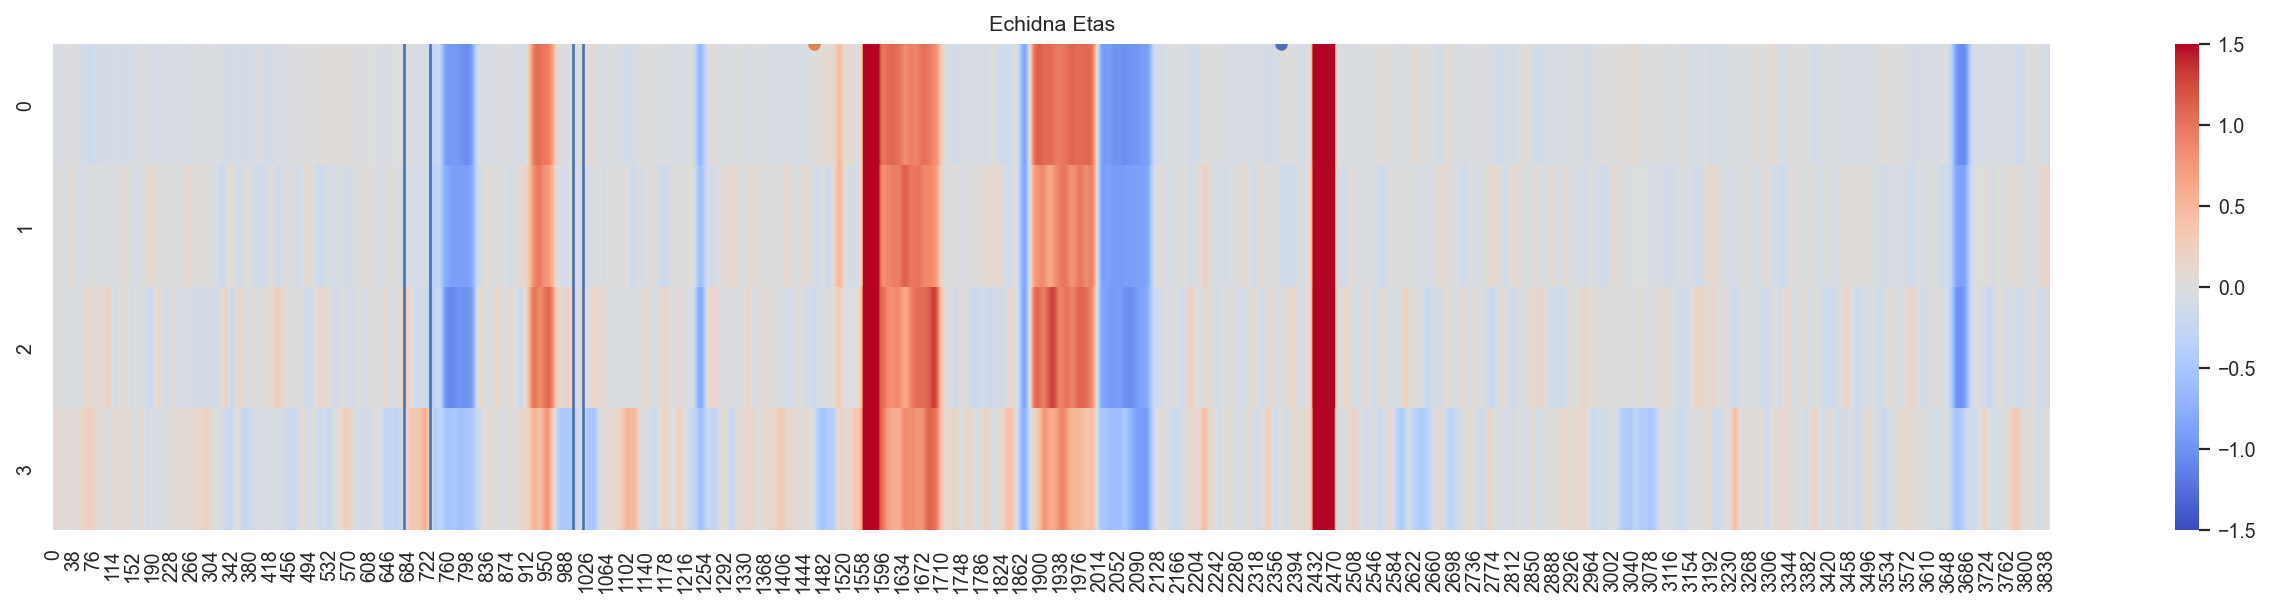

In [590]:
plt.figure(figsize=(20,4))
smooth = scipy.ndimage.gaussian_filter1d(cnvs.loc[mapped_genes].T, sigma=6)
sns.heatmap(smooth, vmin=-1.5, vmax=1.5, cmap='coolwarm')
plt.scatter([list(cnvs.index).index("EGFR")],[0])
plt.scatter([list(cnvs.index).index("PDGFRA")],[0])
plt.axvline(675)
plt.axvline(725)
plt.axvline(1000)
plt.axvline(1020)
plt.title("Echidna Etas")

Text(0.5, 1.0, 'DEFND-Seq SnDNA')

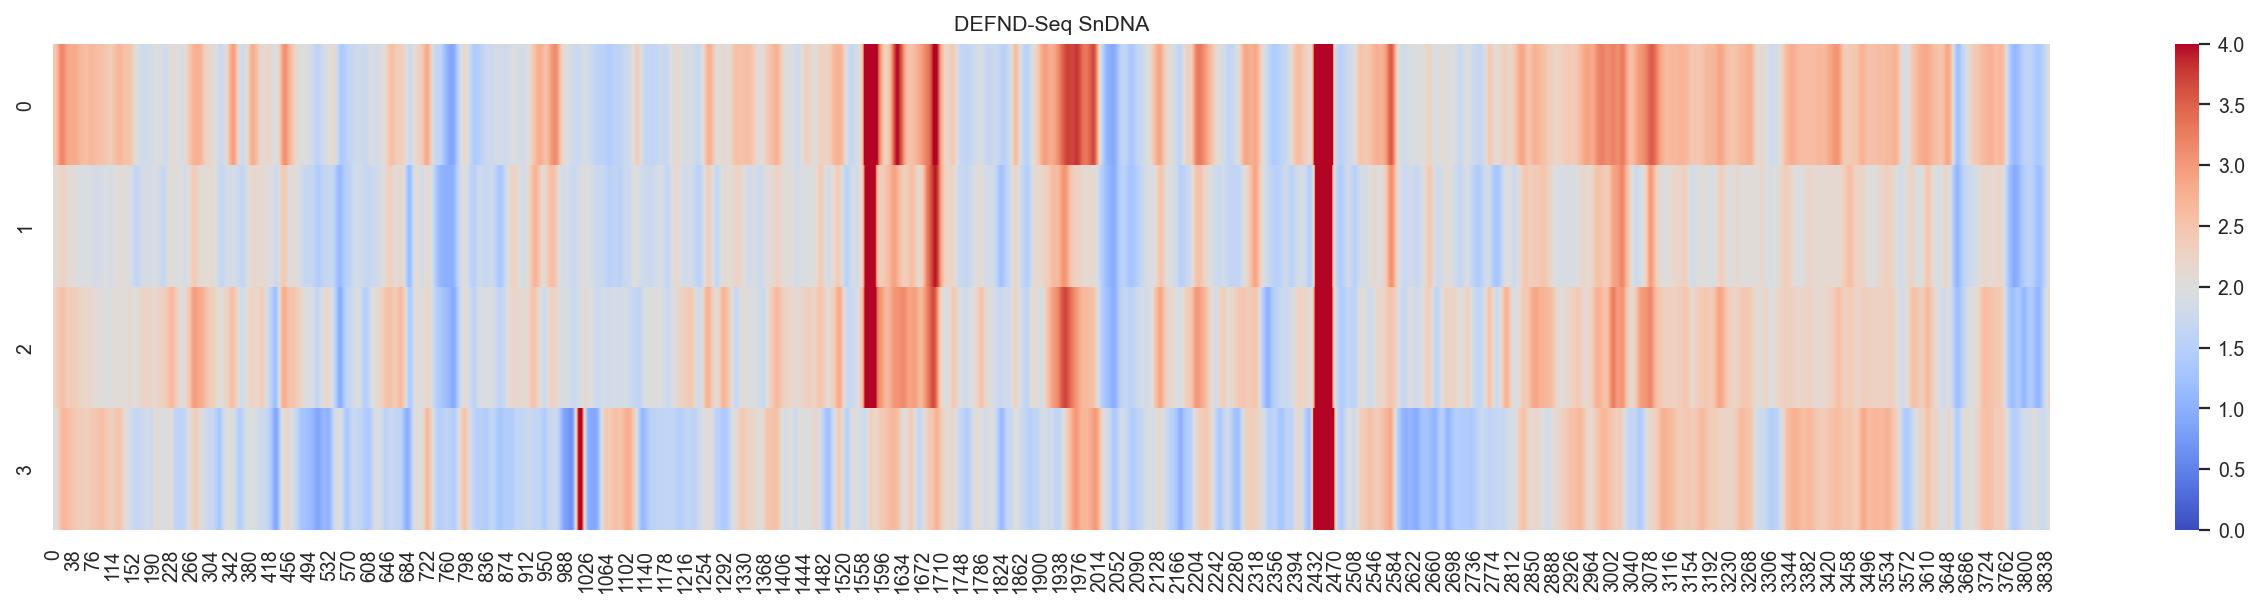

In [591]:
plt.figure(figsize=(20, 4))
smooth = scipy.ndimage.gaussian_filter1d(dna.loc[gene_dna_map].T.loc[['0','1','2','4']], sigma=6)
sns.heatmap(smooth, vmin=0, vmax=4, cmap='coolwarm')
plt.title("DEFND-Seq SnDNA")

In [330]:
cnvs.loc[["EGFR","MDM2","PDGFRA"]]

,echidna_clone_0,echidna_clone_1,echidna_clone_2,echidna_clone_3
geneName,,,,
EGFR,101.154823,88.624916,97.580528,59.930370
MDM2,73.768028,71.328705,72.146530,59.388950
PDGFRA,-0.570927,-0.699603,-0.817323,4.884099


In [587]:
cnvs.loc[["EGFR","MDM2","PDGFRA"]]

,echidna_clone_0,echidna_clone_1,echidna_clone_2,echidna_clone_3
geneName,,,,
EGFR,102.790405,87.209091,98.848862,52.694431
MDM2,74.512932,70.797775,73.064293,54.563873
PDGFRA,-0.648118,-0.733593,-1.067469,5.222435


In [196]:
defnd_genes = dna.loc[gene_dna_map].T
defnd_genes.columns = mapped_genes

In [309]:
defnd_genes = defnd_genes.T

(3845, 6)

2025-07-15 00:55:32,137 | INFO : maxp pruned
2025-07-15 00:55:32,137 | INFO : LTSH dropped
2025-07-15 00:55:32,138 | INFO : cmap pruned
2025-07-15 00:55:32,138 | INFO : kern dropped
2025-07-15 00:55:32,141 | INFO : post pruned
2025-07-15 00:55:32,141 | INFO : PCLT dropped
2025-07-15 00:55:32,141 | INFO : JSTF dropped
2025-07-15 00:55:32,141 | INFO : DSIG dropped
2025-07-15 00:55:32,144 | INFO : GPOS pruned
2025-07-15 00:55:32,145 | INFO : GSUB pruned
2025-07-15 00:55:32,147 | INFO : glyf pruned
2025-07-15 00:55:32,149 | INFO : Added gid0 to subset
2025-07-15 00:55:32,149 | INFO : Added first four glyphs to subset
2025-07-15 00:55:32,150 | INFO : Closing glyph list over 'GSUB': 29 glyphs before
2025-07-15 00:55:32,150 | INFO : Glyph names: ['.notdef', '.null', 'A', 'D', 'E', 'F', 'N', 'S', 'X', 'c', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'n', 'nine', 'nonmarkingreturn', 'one', 'period', 'q', 'r', 'seven', 'six', 'space', 'three', 'two', 'zero']
2025-07-15 00:55:32,150 | INFO : Gly

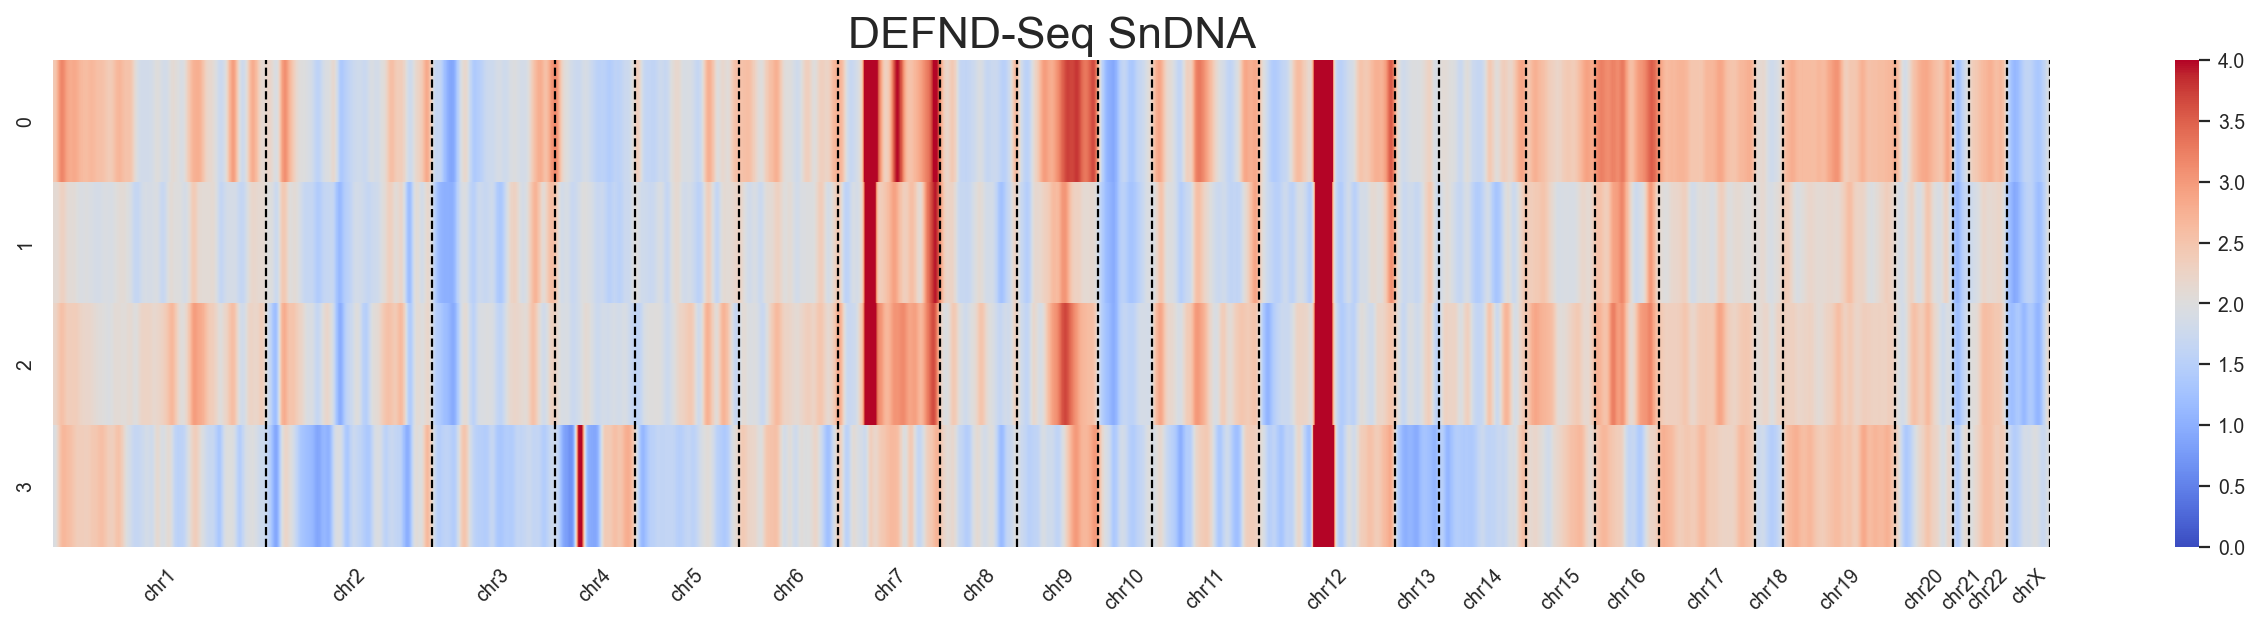

In [316]:
plt.figure(figsize=(20, 4))
smooth = scipy.ndimage.gaussian_filter1d(defnd_genes.iloc[[0,1,2,4]], sigma=6)
sns.heatmap(smooth, vmin=0, vmax=4, cmap='coolwarm')
plt.title("DEFND-Seq SnDNA")
chr_lines, chr_list, gen = eta_no_bin(defnd_genes.T)
ticklines = []
for i in range(len(chr_lines)):
    plt.axvline(x=chr_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(chr_lines[i]-.5*chr_lines[0])
        #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    else:
        ticklines.append(chr_lines[i-1]+.5*(chr_lines[i]-chr_lines[i-1]))
        #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
plt.xticks(ticklines, labels=chr_list, rotation=45)
plt.savefig("DEFND_heatmap.pdf")

In [15]:
adata_cnv = sc.AnnData(cnvs.T)

In [16]:
obs = adata.obs
dic = {}
for i in np.unique(obs["rna_cluster"]):
    sampl = pd.DataFrame(np.unique(obs[obs['rna_cluster']==i]["cell_type"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
    dic[i]= sampl

In [456]:
adata_cnv.obs["defnd_clone"] = [dic[int(i.split("_")[2])] for i in adata_cnv.obs_names]

In [460]:
adata_cnv.obs["cluster"] = adata_cnv.obs_names

In [461]:
adata_cnv.layers["z-score"] = scipy.stats.zscore(adata_cnv.to_df(), axis=0)

2025-07-03 13:43:21,522 | INFO : maxp pruned
2025-07-03 13:43:21,522 | INFO : LTSH dropped
2025-07-03 13:43:21,523 | INFO : cmap pruned
2025-07-03 13:43:21,523 | INFO : kern dropped
2025-07-03 13:43:21,525 | INFO : post pruned
2025-07-03 13:43:21,526 | INFO : PCLT dropped
2025-07-03 13:43:21,526 | INFO : JSTF dropped
2025-07-03 13:43:21,527 | INFO : DSIG dropped
2025-07-03 13:43:21,529 | INFO : GPOS pruned
2025-07-03 13:43:21,530 | INFO : GSUB pruned
2025-07-03 13:43:21,533 | INFO : glyf pruned
2025-07-03 13:43:21,535 | INFO : Added gid0 to subset
2025-07-03 13:43:21,536 | INFO : Added first four glyphs to subset
2025-07-03 13:43:21,536 | INFO : Closing glyph list over 'GSUB': 33 glyphs before
2025-07-03 13:43:21,537 | INFO : Glyph names: ['.notdef', '.null', 'A', 'D', 'E', 'F', 'G', 'M', 'N', 'P', 'R', 'T', 'a', 'c', 'd', 'e', 'eight', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'six', 'space', 'three', 'two', 'underscore', 'zero']
2025-07-03 13:43:21,543 | I

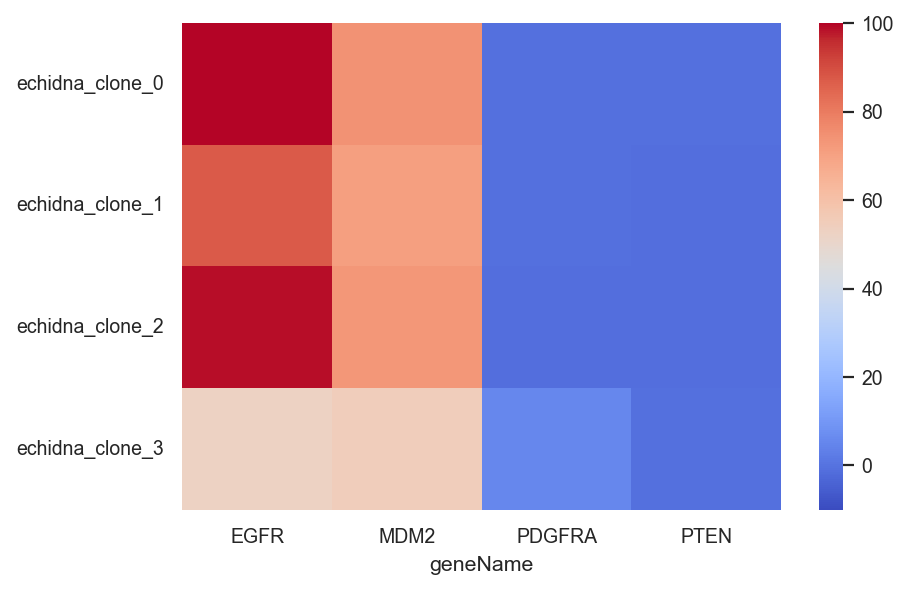

In [141]:
sns.heatmap(cnvs.loc[["EGFR","MDM2","PDGFRA","PTEN"]].T, 
            vmin=-10, vmax=100, cmap='coolwarm')
plt.savefig("key_genes.pdf")

<Axes: >

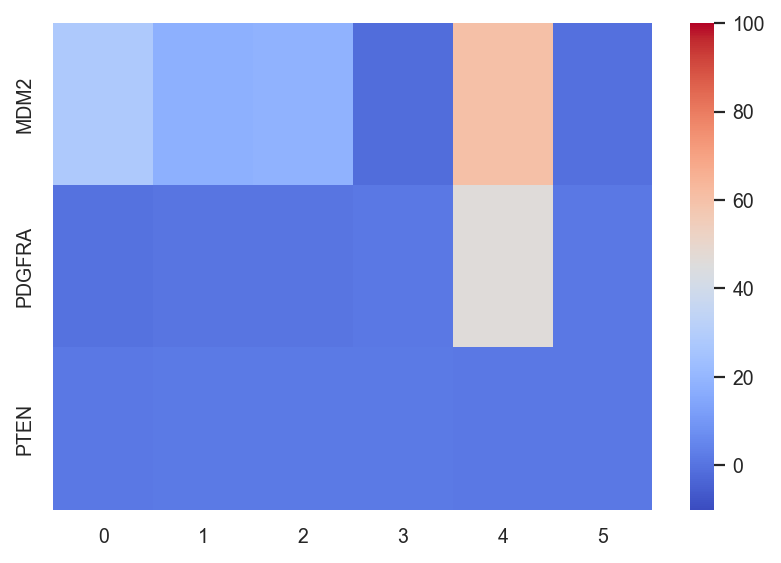

In [285]:
sns.heatmap(defnd_genes[["MDM2","PDGFRA","PTEN"]].T, 
            vmin=-10, vmax=100, cmap='coolwarm')

In [268]:
pseudobulk = adata.to_df().groupby(adata.obs['rna_cluster']).mean()

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_7366/1433596978.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk = adata.to_df().groupby(adata.obs['rna_cluster']).mean()


<Axes: >

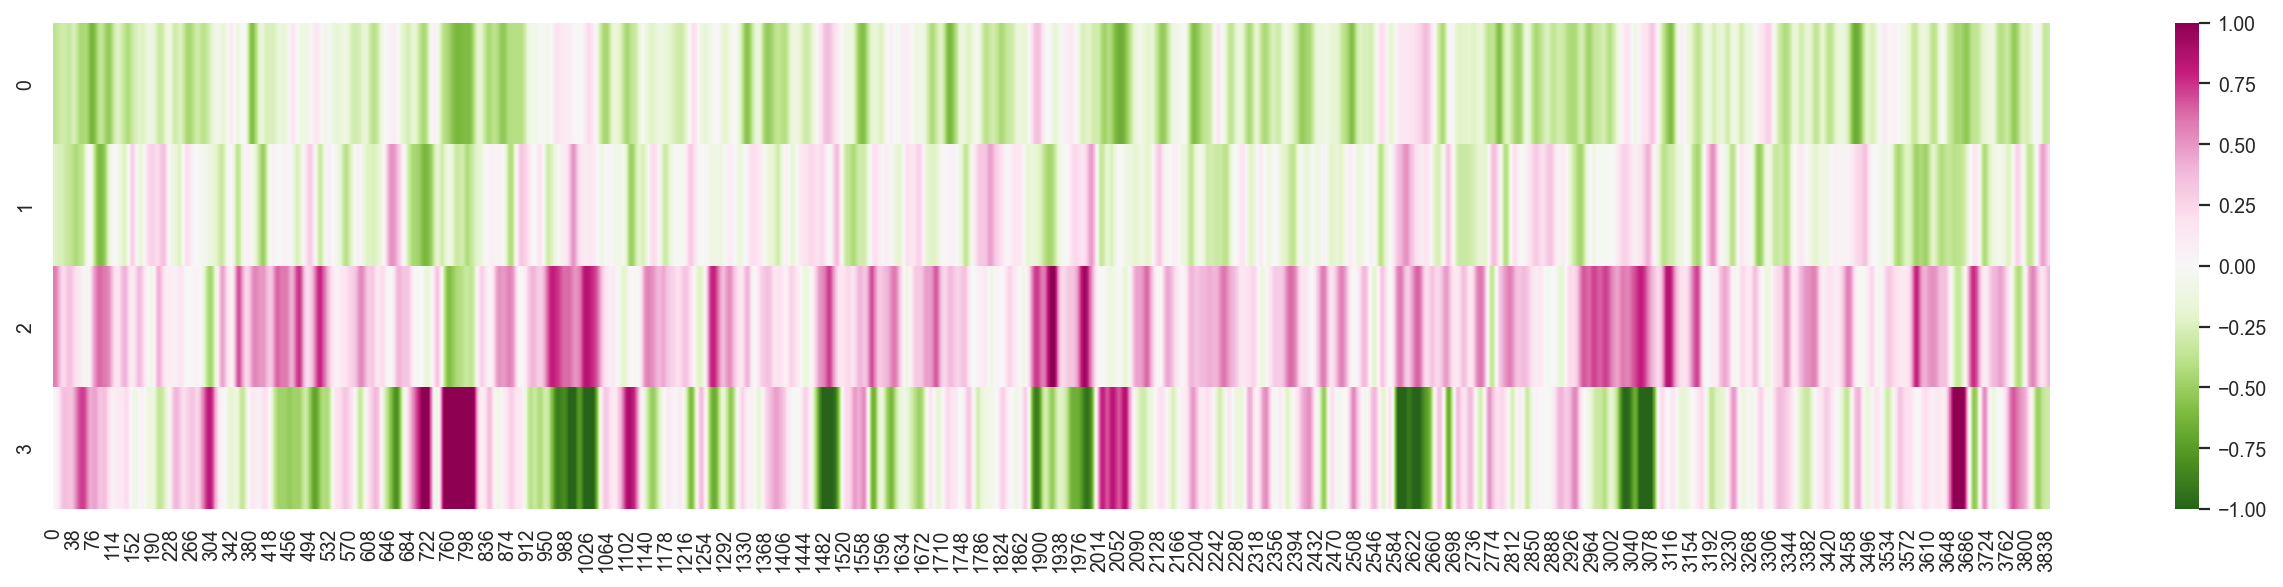

In [296]:
plt.figure(figsize=(20, 4))
smooth = scipy.ndimage.gaussian_filter1d(scipy.stats.zscore(pseudobulk[mapped_genes],axis=0), sigma=7)
plt.axvline(4850)
plt.axvline(4900)
sns.heatmap(smooth, vmin=-1, vmax=1, cmap='PiYG_r')

In [298]:
pseudobulk[["EGFR","MDM2","PDGFRA"]].T

rna_cluster,0,1,2,3
EGFR,4.856440,4.611006,4.943380,2.992424
MDM2,3.823406,3.880682,3.726689,3.411093
PDGFRA,0.183477,0.156306,0.192314,1.199578


In [300]:
sc.tl.rank_genes_groups(adata, groupby="cell_type", method='wilcoxon')
deg = sc.get.rank_genes_groups_df(adata, group="Tumor_PDGFRA").sort_values(by="logfoldchanges",ascending=True)

In [301]:
deg = deg[deg["pvals_adj"]<.05]

In [302]:
genes = deg[deg["logfoldchanges"]>0]["names"]

In [73]:
ordered_genes = np.load("ordered_genes.npy")
ordchrs = np.load("ordered_chrs.npy")
pal = {"del":"blue","neut":"grey","amp":"red"}

def eta_no_bin(eta):
    inds = []
    draw_lines = []
    ch = 'chr1'
    chr_list = [ch]
    count=0
    for i in range(len(ordered_genes)):
        if ordered_genes[i] in eta.index:
            inds.append(ordered_genes[i])
            count+=1
            if ordchrs[i]!=ch:
                draw_lines.append(count)
                ch=ordchrs[i]
                chr_list.append(ch)
    draw_lines.append(count)
    return draw_lines, chr_list, inds

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_7366/561634403.py:53: RuntimeWarning: Mean of empty slice.
  if smooth[3,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.1:
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(231.70356234096693, 0.5, '')

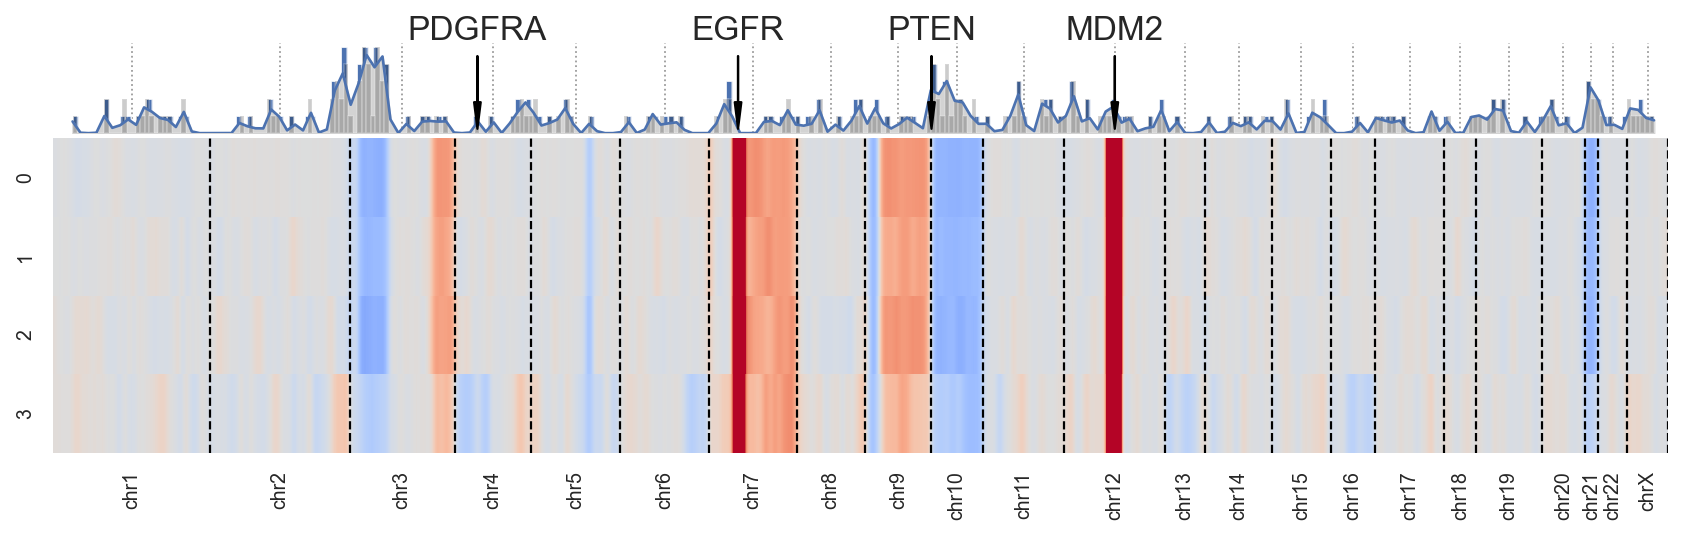

In [303]:
from adjustText import adjust_text
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((23,22), (3,1), colspan=19, rowspan=10)
ax2 = plt.subplot2grid((23,22), (0,1), colspan=19, rowspan=3,sharex = ax1)
smooth = scipy.ndimage.gaussian_filter1d(cnvs.T, sigma=10)
sns.heatmap(smooth, cmap='coolwarm', vmin=-2, vmax=2, ax=ax1, cbar=False)

# Rasterize the heatmap (which is a QuadMesh object)
for artist in ax1.collections:
    artist.set_rasterized(True)

genes = np.intersect1d(genes, cnvs.index)
draw_lines = [list(cnvs.index).index(i) for i in genes]

#sns.kdeplot(draw_lines, bw_adjust=.1, ax=ax2, fill=True, color="pink")

density = []
for gene in genes:
    density.append(list(cnvs.index).index(gene))
#get max height of histogram bars
counts, bin_edges, patches = plt.hist(density, bins=300)
ax_hist = sns.histplot(density, bins=300, kde=True, kde_kws=dict(bw_adjust=.02), ax=ax2)
# Extract KDE data
kde_line = ax_hist.get_lines()[0]  # The first line corresponds to the KDE
kde_x = kde_line.get_xdata()
kde_y = kde_line.get_ydata()

#plt.clf()   

#plt.plot(kde_x, kde_y)
ax2.fill_between(kde_x, 0, kde_y, color='lightgrey')


# Find peaks
peaks, _ = find_peaks(kde_y, prominence=.5)

# Find peak widths
results_full = peak_widths(kde_y, peaks, rel_height=0.5)  # Width at half prominence


# Interpolated x-coordinates for the widths
left_coords = results_full[2]
right_coords = results_full[3]

# Convert interpolated coordinates to indices
left_indices = np.round(left_coords).astype(int)
right_indices = np.round(right_coords).astype(int)

#figure out which peaks correspond to amps
hotspot_inds = []
for i in range(len(left_coords)):
    #print(smooth[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean())
    if smooth[3,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.1:
        hotspot_inds.append(i)
        
peaks = peaks[hotspot_inds]
left_indices = left_indices[hotspot_inds]
right_indices = right_indices[hotspot_inds]

chr_lines, chr_list, gen = eta_no_bin(cnvs)
ticklines = []
for i in range(len(chr_lines)):
    ax1.axvline(x=chr_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(chr_lines[i]-.5*chr_lines[0])
        #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    else:
        ticklines.append(chr_lines[i-1]+.5*(chr_lines[i]-chr_lines[i-1]))
        #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
plt.xticks(ticklines, labels=chr_list, rotation=45)

for gene in ["EGFR","MDM2","PDGFRA","PTEN"]:
    gene_idx = list(cnvs.index).index(gene)

    plt.annotate(
        gene,
        xy=(gene_idx, 0),
        xytext=(gene_idx, 5),  # Move label upward (positive y)
        textcoords='data',      # Position relative to data coordinates
        ha='center',            # Center text horizontally
        va='bottom',            # Align text above the arrow tip
        arrowprops=dict(
            facecolor='black',
            shrink=0.05,
            width=.1,            # Width of arrow shaft
            headwidth=3,        # Width of arrow head
            edgecolor='black',
            linewidth=1         # Thickness of the arrow edge
        )
    )  

    
ax2.hist(draw_lines, bins=350, color='black', alpha=.2)
ax2.set_yticks([])
ax2.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)  # Remove left spine
ax2.spines["bottom"].set_visible(False)
ax2.set_ylabel(None)

#plt.savefig("Cluster_3_hotspots.pdf", bbox_inches="tight")

In [75]:
left, right = np.round(kde_x[left_indices]).astype(int), np.round(kde_x[right_indices]).astype(int)

In [276]:
scipy.stats.zscore(pseudobulk[dn+up], axis=0)

,PPP2R2C,SLC38A1,EGFR,RBPMS,CACNA2D1,SLC44A5,LMO3,PDGFD,EYA4,SHROOM3,HOXD10,FMO3,EMILIN1,POSTN,PDGFRA,GALR1,C1R,GPC1,COL6A1,WNT5A
rna_cluster,,,,,,,,,,,,,,,,,,,,
0,0.791049,0.917206,0.637067,0.794147,0.509553,0.416758,0.834240,0.719809,0.622043,0.974346,-0.641692,-0.490634,-0.655424,-0.591676,-0.563291,-0.532228,-0.663402,-0.571250,-0.639374,-0.767097
1,-0.120793,0.024186,0.327831,0.129831,0.513806,1.116098,0.625157,-0.587037,0.008728,-0.194884,-0.640921,-0.685023,-0.568907,-0.712557,-0.624648,-0.653255,-0.475326,-0.528194,-0.610039,-0.526860
2,0.916877,0.694431,0.746607,0.747476,0.703377,0.071968,0.231630,1.184304,0.991146,0.774075,-0.443799,-0.552114,-0.505258,-0.418321,-0.543334,-0.544647,-0.589431,-0.631442,-0.479498,-0.424660
3,-1.587132,-1.635823,-1.711505,-1.671453,-1.726737,-1.604824,-1.691027,-1.317075,-1.621917,-1.553537,1.726411,1.727771,1.729589,1.722553,1.731273,1.730130,1.728159,1.730886,1.728911,1.718617


In [76]:
hotspot_nr = []
for i in range(len(left)):
    print(np.intersect1d(cnvs.index[left[i]:right[i]], genes))
    hotspot_nr += list(np.intersect1d(cnvs.index[left[i]:right[i]], genes))

['CTTNBP2NL' 'DDR2' 'DNM3' 'GNAI3' 'MCL1' 'S100A6' 'TBX15']
['DNER' 'PID1' 'PTMA' 'SERPINE2']
['CP' 'DGKG' 'KCNMB2' 'TIPARP']
['DDX60L' 'ELF2' 'GPM6A' 'GRIA2' 'PDGFC' 'PDLIM3']
['BMPER' 'GPNMB' 'JAZF1' 'PDE1C' 'THSD7A']
['CALD1' 'TMEM178B' 'ZC3HAV1']
['ADCY8' 'HAS2' 'KHDRBS3' 'SYBU']
['GSN' 'HSPA5' 'LPAR1']
['AHNAK' 'CELF1' 'MALAT1' 'NEAT1' 'RTN3']
['HMGA2-AS1' 'LINC02384' 'LINC02821' 'LRP1']
['CRTC3' 'GLCE' 'NEO1' 'NTRK3']
['ABCA8' 'CDC42EP4']
['EIF1AX' 'MAOB' 'TSPAN7']


In [77]:
hs_relevant = ['DNER', 'PID1', 'PTMA', 'PDGFC', 'GPNMB', 'JAZF1', 'THSD7A', 'CALD1', 'HAS2', 'KHDRBS3', 
            'HSPA5', 'LPAR1', 'AHNAK', 'MALAT1', 'NEAT1', 'CRTC3', 'GLCE', 'NEO1', 'NTRK3', 'TSPAN7', 'EIF1AX']

In [37]:
list(cnvs.index).index(gene)

5476

In [53]:
for i in hs_relevant: 
    if i not in hotspot_nr:
        print(i)

In [304]:
genes = deg[deg["logfoldchanges"]<0]["names"]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_7366/3071405294.py:55: RuntimeWarning: Mean of empty slice.
  if smooth[3,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()<-.1:
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-07-14 02:00:44,674 | INFO : maxp pruned
2025-07-14 02:00:44,675 | INFO : LTSH dropped
2025-07-14 02:00:44,675 | INFO : cmap pruned
2025-07-14 02:00:44,676 | INFO : kern dropped
2025-07-14 02:00:44,678 | INFO : post pruned
2025-07-14 02:00:44,678 | INFO : PCLT dropped
2025-07-14 02:00:44,679 | INFO : JSTF dropped
2025-07-14 02:00:44,679 | INFO : DSIG dropped
2025-07-14 02:00:44,681 | INFO : GPOS pruned
2025-07-14 02:00:44,682 | INFO : GSUB pruned
2025-07-14 02:00:44,685 | INFO : glyf pruned
2025-07-14 02:00:44,686 | INFO : Added gid0 to subset
2025-07-14 02:00:44,686 | INF

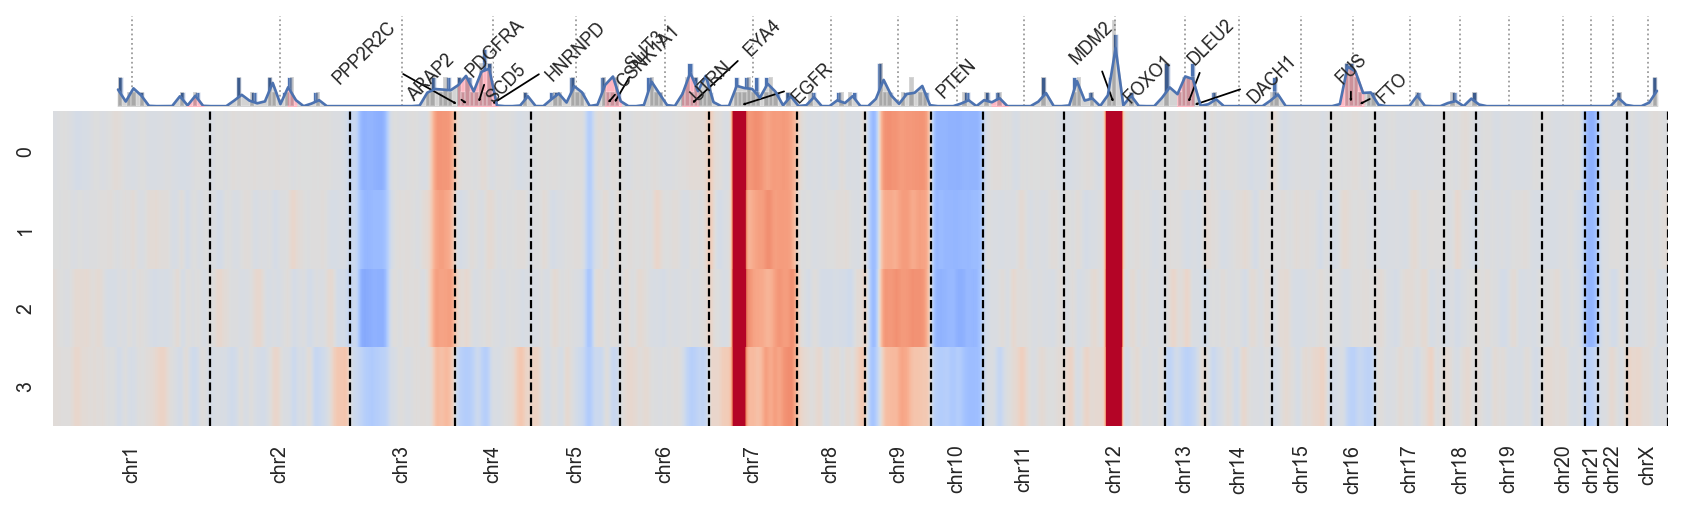

In [305]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((23,22), (3,1), colspan=19, rowspan=10)
ax2 = plt.subplot2grid((23,22), (0,1), colspan=19, rowspan=3,sharex = ax1)
smooth = scipy.ndimage.gaussian_filter1d(cnvs.T, sigma=10)
sns.heatmap(smooth, cmap='coolwarm', vmin=-2, vmax=2, ax=ax1, cbar=False)

# Rasterize the heatmap (which is a QuadMesh object)
for artist in ax1.collections:
    artist.set_rasterized(True)

genes = np.intersect1d(genes, cnvs.index)
draw_lines = [list(cnvs.index).index(i) for i in genes]

#sns.kdeplot(draw_lines, bw_adjust=.1, ax=ax2, fill=True, color="pink")

density = []
for gene in genes:
    density.append(list(cnvs.index).index(gene))
#get max height of histogram bars
counts, bin_edges, patches = plt.hist(density, bins=300)
ax_hist = sns.histplot(density, bins=300, kde=True, kde_kws=dict(bw_adjust=.02), ax=ax2)
# Extract KDE data
kde_line = ax_hist.get_lines()[0]  # The first line corresponds to the KDE
kde_x = kde_line.get_xdata()
kde_y = kde_line.get_ydata()

#plt.clf()   

#plt.plot(kde_x, kde_y)
ax2.fill_between(kde_x, 0, kde_y, color='lightgrey')


# Find peaks
peaks, _ = find_peaks(kde_y, prominence=.5)

# Find peak widths
results_full = peak_widths(kde_y, peaks, rel_height=0.5)  # Width at half prominence


# Interpolated x-coordinates for the widths
left_coords = results_full[2]
right_coords = results_full[3]

# Convert interpolated coordinates to indices
left_indices = np.round(left_coords).astype(int)
right_indices = np.round(right_coords).astype(int)

#figure out which peaks correspond to amps
hotspot_inds = []
for i in range(len(left_coords)):
    #THIS IS DIFFERENT FROM OTHER ITERATIONS OF THIS CODE; HERE WE ONLY CONSIDER THE CLONE 3
    if smooth[3,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()<-.1:
        hotspot_inds.append(i)
        
peaks = peaks[hotspot_inds]
left_indices = left_indices[hotspot_inds]
right_indices = right_indices[hotspot_inds]


chr_lines, chr_list, gen = eta_no_bin(cnvs)
ticklines = []
for i in range(len(chr_lines)):
    ax1.axvline(x=chr_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(chr_lines[i]-.5*chr_lines[0])
        #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    else:
        ticklines.append(chr_lines[i-1]+.5*(chr_lines[i]-chr_lines[i-1]))
        #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
plt.xticks(ticklines, labels=chr_list, rotation=45)

for i in range(len(left_indices)):
    ax2.fill_between(kde_x[left_indices[i]:right_indices[i]+1], 0, kde_y[left_indices[i]:right_indices[i]+1], color='lightpink')

texts = []
for gene in cs_relevant:
    texts.append(ax2.text(list(cnvs.index).index(gene), 0, gene, rotation=45, fontsize=8))
for gene in ["EGFR","MDM2","PDGFRA","PTEN"]:
    texts.append(ax2.text(list(cnvs.index).index(gene), 0, gene, rotation=45, fontsize=8,))    
    
ax2.hist(draw_lines, bins=350, color='black', alpha=.2)
ax2.set_yticks([])
ax2.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)  # Remove left spine
ax2.spines["bottom"].set_visible(False)
ax2.set_ylabel(None)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
plt.savefig("Cluster_3_coldspots.pdf", bbox_inches="tight")

In [56]:
left, right = np.round(kde_x[left_indices]).astype(int), np.round(kde_x[right_indices]).astype(int)

In [61]:
coldspot_nr = []
for i in range(len(left)):
    print(np.intersect1d(cnvs.index[left[i]:right[i]], genes))
    coldspot_nr += list(np.intersect1d(cnvs.index[left[i]:right[i]], genes))

['DNAH14']
['COBLL1' 'RBMS1']
['ADGRA3' 'ARAP2' 'LCORL' 'PPP2R2C' 'RAB28']
['ADAMTS3' 'ANKRD17' 'HNRNPD' 'HNRNPDL' 'LIMCH1' 'MTHFD2L' 'SCD5'
 'SHROOM3']
['CREBRF' 'CSNK1A1' 'EBF1' 'NSG2' 'SLIT3']
['AHI1' 'EPM2A' 'EYA4' 'FAM184A' 'MOXD1' 'UTRN']
['LDHC']
['DACH1' 'DLEU2' 'FNDC3A' 'FOXO1' 'PIBF1' 'TPT1-AS1']
['CHD9' 'DYNC1LI2' 'FTO' 'FUS' 'GPRC5B' 'ITFG1' 'PHKB' 'SHISA9' 'TNRC6A']


In [62]:
cs_relevant = ['PPP2R2C', 'ARAP2', 'HNRNPD', 'SCD5', 'CSNK1A1', 'SLIT3', 'EYA4', 'UTRN', 'DACH1', 'DLEU2', 'FOXO1', 
               'FTO', 'FUS']

In [59]:
for i in cs_relevant: 
    if i not in hotspot_nr:
        print(i)

2025-06-24 21:17:04,869 | INFO : maxp pruned
2025-06-24 21:17:04,869 | INFO : LTSH dropped
2025-06-24 21:17:04,870 | INFO : cmap pruned
2025-06-24 21:17:04,870 | INFO : kern dropped
2025-06-24 21:17:04,872 | INFO : post pruned
2025-06-24 21:17:04,873 | INFO : PCLT dropped
2025-06-24 21:17:04,873 | INFO : JSTF dropped
2025-06-24 21:17:04,873 | INFO : DSIG dropped
2025-06-24 21:17:04,875 | INFO : GPOS pruned
2025-06-24 21:17:04,877 | INFO : GSUB pruned
2025-06-24 21:17:04,879 | INFO : glyf pruned
2025-06-24 21:17:04,881 | INFO : Added gid0 to subset
2025-06-24 21:17:04,881 | INFO : Added first four glyphs to subset
2025-06-24 21:17:04,881 | INFO : Closing glyph list over 'GSUB': 48 glyphs before
2025-06-24 21:17:04,882 | INFO : Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period'

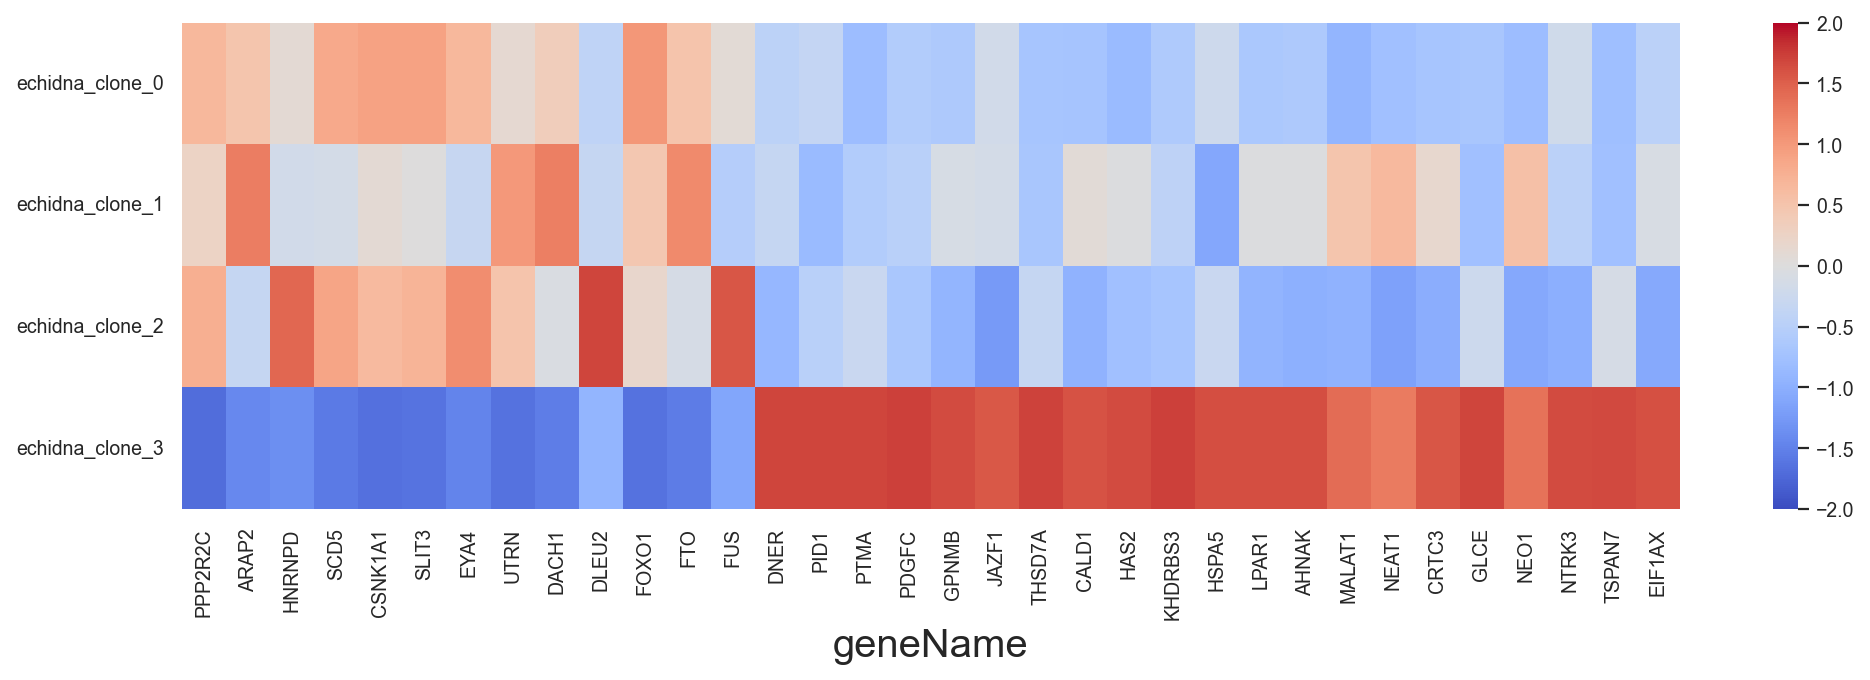

In [647]:
plt.figure(figsize=(15,4))
sns.heatmap(scipy.stats.zscore(cnvs.loc[cs_relevant+hs_relevant].T,axis=0), 
            vmin=-2, vmax=2, cmap='coolwarm')
plt.savefig("relevant_genes.pdf")

In [191]:
dna

,0,1,2,3,4,5
genomic_bin,,,,,,
chr1:800000-900000,2.849830,2.735158,2.414154,1.872984,2.534257,2.277871
chr1:900000-1000000,3.785233,2.435868,2.836433,1.799342,3.481592,2.262456
chr1:1000000-1100000,4.013265,2.411783,2.844985,1.828978,2.508811,2.338795
chr1:1100000-1200000,4.284856,2.600700,3.022595,1.975096,3.302782,2.437312
chr1:1200000-1300000,4.197790,1.906863,2.689197,1.775982,3.540396,2.549017
...,...,...,...,...,...,...
chrX:155400000-155500000,2.323514,2.370744,1.969773,1.661352,1.980146,1.354278
chrX:155600000-155700000,1.921461,2.257956,1.613514,1.262138,1.884752,1.653798
chrX:155700000-155800000,2.188169,2.163139,1.691446,1.743781,2.551858,1.761557


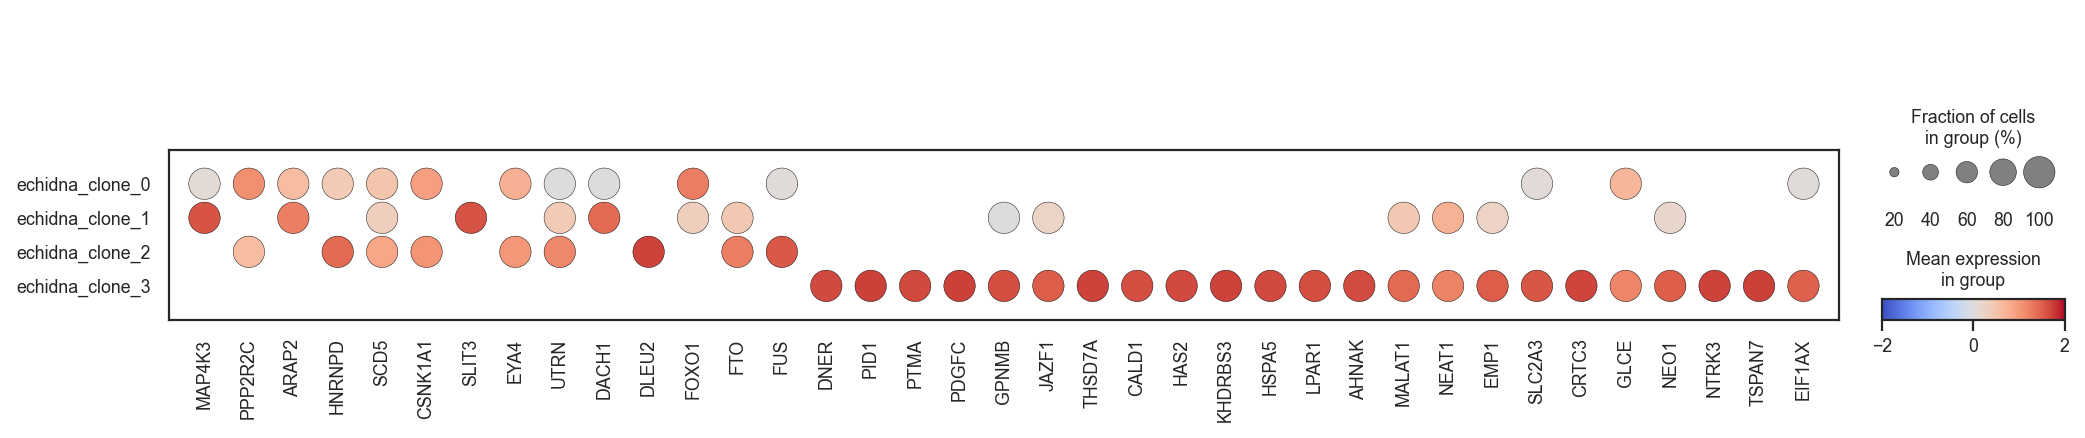

In [499]:
sc.pl.dotplot(adata_cnv,cs_relevant+hs_relevant,
              groupby='cluster', layer='z-score',cmap='coolwarm', vmin=-2, vmax=2)

In [201]:
np.intersect1d(cs_relevant+hs_relevant, defnd_genes.columns)

array(['AHNAK', 'CRTC3', 'CSNK1A1', 'EIF1AX', 'FOXO1', 'FUS', 'GLCE',
       'GPNMB', 'HAS2', 'HNRNPD', 'HSPA5', 'MALAT1', 'NEAT1', 'PTMA',
       'SCD5', 'TSPAN7'], dtype=object)

<Axes: >

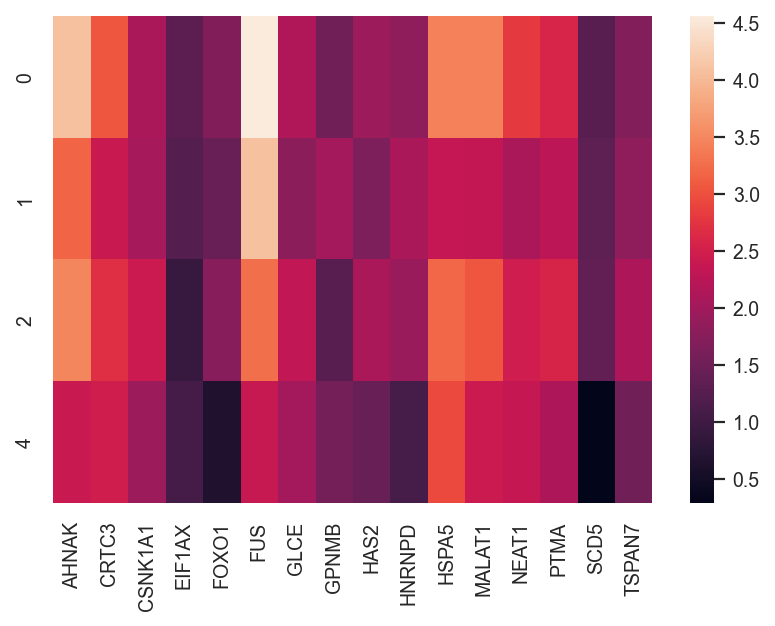

In [206]:
sns.heatmap(defnd_genes[np.intersect1d(cs_relevant+hs_relevant, defnd_genes.columns)].loc[['0','1','2','4']])

<Axes: xlabel='geneName'>

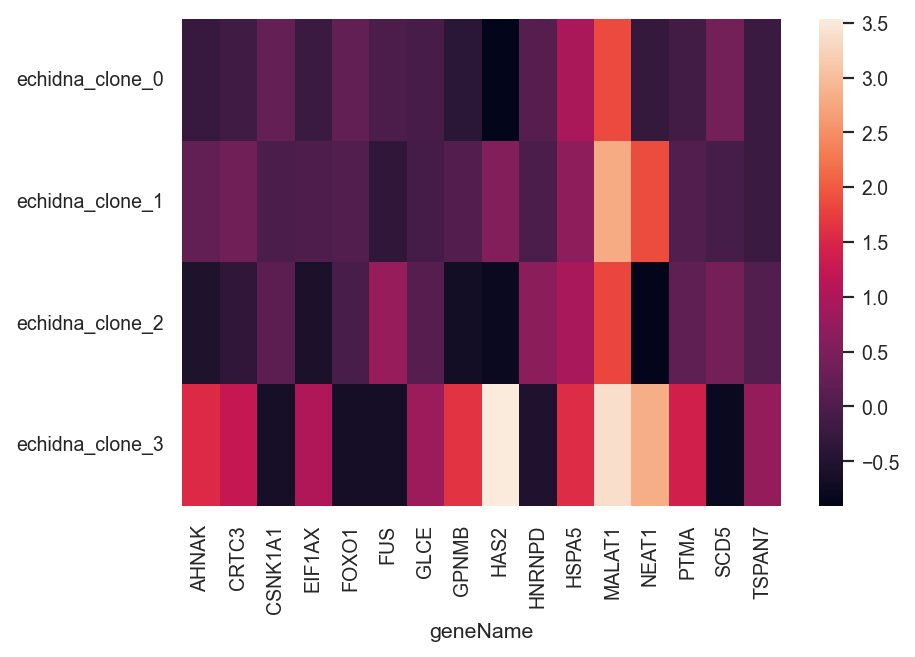

In [207]:
sns.heatmap(cnvs.loc[np.intersect1d(cs_relevant+hs_relevant, defnd_genes.columns)].T)

In [208]:
hotspot_corrs = pd.DataFrame()
for g in hotspot_nr:
    if g in defnd_genes.columns:
        hotspot_corrs[g]=scipy.stats.pearsonr(cnvs.loc[g], defnd_genes[g].loc[['0','1','2','4']])

In [216]:
hotspot_corrs.T.sort_values(by=0, ascending=False)

,0,1
GRIA2,0.994442,0.005558
HMGA2-AS1,0.892948,0.107052
MAOB,0.882378,0.117622
CDC42EP4,0.879445,0.120555
ELF2,0.799909,0.200091
PDLIM3,0.709425,0.290575
HSPA5,0.275598,0.724402
LINC02821,0.257096,0.742904
GPNMB,0.226800,0.773200
GLCE,0.030174,0.969826


<Axes: >

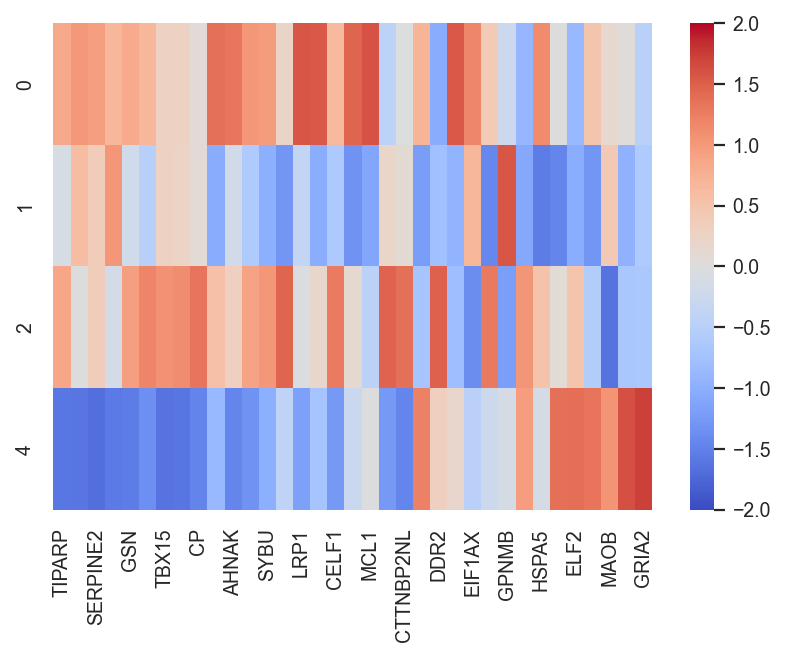

In [228]:
sns.heatmap(scipy.stats.zscore(defnd_genes[hotspot_corrs.T.sort_values(by=0, ascending=True).index].loc[['0','1','2','4']]
                               ,axis=0), cmap='coolwarm',vmax=2, vmin=-2)

<Axes: >

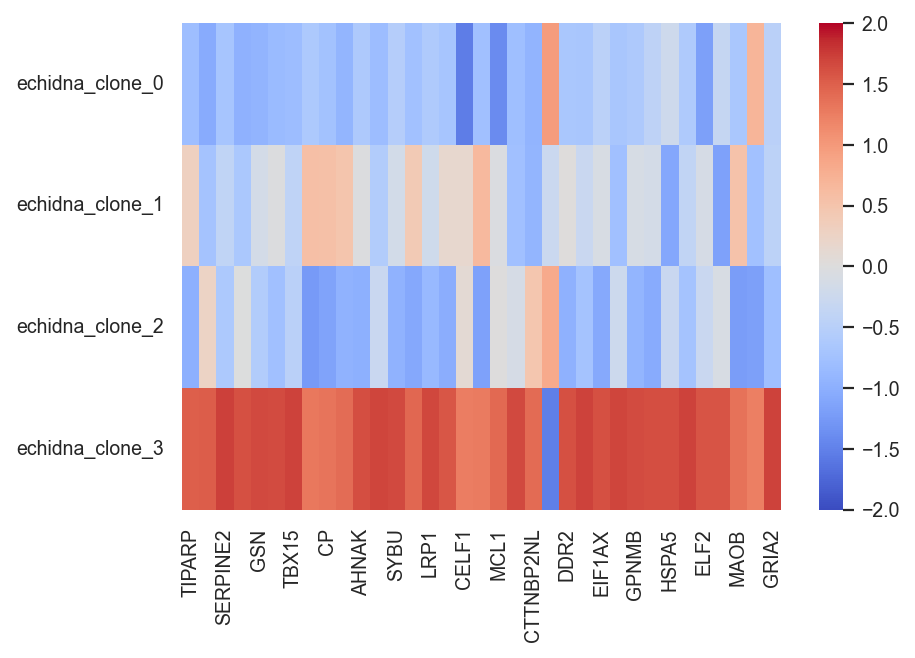

In [229]:
sns.heatmap(scipy.stats.zscore(cnvs.loc[hotspot_corrs.T.sort_values(by=0, ascending=True).index].T,axis=0)
            ,cmap='coolwarm',vmax=2, vmin=-2)

In [224]:
coldspot_corrs = pd.DataFrame()
for g in coldspot_nr:
    if g in defnd_genes.columns:
        coldspot_corrs[g]=scipy.stats.pearsonr(cnvs.loc[g], defnd_genes[g].loc[['0','1','2','4']])

In [225]:
coldspot_corrs.T.sort_values(by=0, ascending=False)

,0,1
HNRNPDL,0.951364,0.048636
FOXO1,0.920710,0.079290
SCD5,0.903689,0.096311
DYNC1LI2,0.843500,0.156500
LDHC,0.810133,0.189867
RAB28,0.794401,0.205599
GPRC5B,0.783345,0.216655
TPT1-AS1,0.766329,0.233671
HNRNPD,0.724639,0.275361
CSNK1A1,0.623353,0.376647
